# Uncertainty analysis

Here we will demonstrate a full uncertainty analysis of the inversion. We use a stochastic approach, where we 1) choose the important input parameters to the inversion, 2) define each of there uncertainty distributions, 3) run a series of inversions which sample these inputs from their uncertainty distributions, and 4) use the ensemble of inverted topography models to define the mean result and the uncertainty.

## Import packages

In [30]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import copy
import logging
import pathlib
import pickle
import string

import numpy as np
import scipy as sp
import verde as vd
import xarray as xr
from polartoolkit import maps, profiles
from polartoolkit import utils as polar_utils

from invert4geom import (
    plotting,
    regional,
    uncertainty,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load results from notebook `Combining it all`

In [61]:
# load pickle files
params = []
with pathlib.Path("tmp/combining_it_all_results.pickle").open("rb") as file:
    while True:
        try:
            params.append(pickle.load(file))
        except EOFError:
            break
(
    grav_df,
    constraint_points,
    starting_topography_kwargs,
    grids,
    inversion_results,
    kwargs,
    regional_grav_kwargs,
    _,
) = params

In [3]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
grav_df.describe()

,northing,easting,upward,upper_surface_grav,lower_surface_grav,observed_grav,gravity_anomaly,uncert,starting_gravity,true_res,misfit,reg,res
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1271.0,1271.000000,1271.000000,1271.000000,1.271000e+03,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.128924,0.004007,-0.124917,-0.124917,0.1,1.130048,-1.258972,-1.254965,-7.021979e-01,-0.552767
std,8947.792584,11836.81698,0.0,7.128555,0.714063,7.271000,7.269461,0.0,6.906876,4.602393,4.828938,1.110660e-16,4.828938
min,0.000000,0.00000,1001.0,-17.179165,-1.033526,-16.887669,-17.040892,0.1,-8.029374,-19.592049,-19.972714,-7.021979e-01,-19.270516
25%,7000.000000,10000.00000,1001.0,-5.448853,-0.601914,-5.750137,-5.739415,0.1,-4.384273,-3.001264,-3.103592,-7.021979e-01,-2.401394
50%,15000.000000,20000.00000,1001.0,-1.160222,-0.153040,-0.758131,-0.713654,0.1,-0.620986,-1.444045,-1.845960,-7.021979e-01,-1.143762
75%,23000.000000,30000.00000,1001.0,3.675021,0.541706,3.825804,3.815224,0.1,5.463603,0.461464,0.793943,-7.021979e-01,1.496141
max,30000.000000,40000.00000,1001.0,19.599674,1.599823,19.781652,19.936108,0.1,23.315668,13.969991,14.301612,-7.021979e-01,15.003810


In [4]:
constraint_points.describe()

,easting,northing,true_upward,upward,uncert,weight,inverted_topography
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,18971.649226,16518.655913,489.096872,487.025168,9.781937,0.011132,489.043995
std,10839.669022,8540.046257,79.152932,81.118110,1.583059,0.003039,81.974472
min,3505.581182,1697.178371,406.379413,405.305719,8.127588,0.005624,399.717642
25%,11575.107009,10553.975772,429.926990,424.663596,8.598540,0.009240,431.849241
50%,19995.535031,16357.717739,454.924262,458.214230,9.098485,0.012080,455.590917
75%,27651.208305,24233.535276,520.183444,514.207570,10.403669,0.013525,524.127350
max,38163.601456,27603.626012,666.725645,668.402196,13.334513,0.015138,665.539254


In [5]:
true_topography = grids.true
lower_topography = grids.lower
starting_topography = grids.starting
final_topography = grids.inverted

In [6]:
topo_results, grav_results, parameters, elapsed_time = inversion_results

In [7]:
kwargs

{'max_iterations': 200,
 'l2_norm_tolerance': 0.3,
 'delta_l2_norm_tolerance': 1.008}

In [8]:
regional_grav_kwargs["constraints_df"] = constraint_points
regional_grav_kwargs

{'method': 'constraints',
 'grid_method': 'eq_sources',
 'constraints_weights_column': 'weight',
 'cv': True,
 'cv_kwargs': {'n_trials': 200,
  'damping_limits': (1e-10, 1),
  'progressbar': False,
  'fname': 'tmp/regional_sep'},
 'depth': 'default',
 'block_size': None,
 'constraints_df':          easting      northing  true_upward      upward     uncert    weight  \
 0    3899.714996  26468.618776   666.725645  668.402196  13.334513  0.005624   
 1   30636.914105   6974.789900   406.379413  405.305719   8.127588  0.015138   
 2   17659.550795  13659.470931   480.393921  486.547024   9.607878  0.010833   
 3   28491.676758  27073.768551   517.183455  518.268507  10.343669  0.009347   
 4   38163.601456   1697.178371   435.459979  430.794727   8.709200  0.013184   
 5   21462.843076  17815.369689   454.924262  458.214230   9.098485  0.012080   
 6   20042.577619  27603.626012   411.155008  421.877931   8.223100  0.014789   
 7    3737.943068   7448.480613   582.902996  593.944123  11.6

In [62]:
starting_topography_kwargs

{'method': 'splines',
 'region': [0, 40000, 0, 30000],
 'spacing': 1000,
 'constraints_df':          easting      northing  true_upward      upward     uncert    weight  \
 0    3899.714996  26468.618776   666.725645  668.402196  13.334513  0.005624   
 1   30636.914105   6974.789900   406.379413  405.305719   8.127588  0.015138   
 2   17659.550795  13659.470931   480.393921  486.547024   9.607878  0.010833   
 3   28491.676758  27073.768551   517.183455  518.268507  10.343669  0.009347   
 4   38163.601456   1697.178371   435.459979  430.794727   8.709200  0.013184   
 5   21462.843076  17815.369689   454.924262  458.214230   9.098485  0.012080   
 6   20042.577619  27603.626012   411.155008  421.877931   8.223100  0.014789   
 7    3737.943068   7448.480613   582.902996  593.944123  11.658060  0.007358   
 8   11200.681244  16357.717739   511.624141  504.423182  10.232483  0.009551   
 9   19995.535031  26455.594497   450.505648  439.104058   9.010113  0.012318   
 10  26810.739853 

# Extract parameters

In [9]:
parameters

{'Density contrast(s)': '[2857.9296283] kg/m3',
 'Reference level': '487.0251682643297 m',
 'Max iterations': 200,
 'L2 norm tolerance': '0.3',
 'Delta L2 norm tolerance': '1.008',
 'Deriv type': 'annulus',
 'Solver type': 'scipy least squares',
 'Solver damping': 0.021017217578137074,
 'Upper confining layer': 'Not enabled',
 'Lower confining layer': 'Not enabled',
 'Regularization weighting grid': 'Not enabled',
 'Time elapsed': '0 seconds',
 'Avg. iteration time': '0.14 seconds',
 'Final misfit RMSE / L2-norm': '0.0876 /0.296 mGal',
 'Termination reason': ['l2-norm tolerance'],
 'Iteration times': [0.13145220704609528,
  0.15002987801562995,
  0.14759599702665582]}

In [10]:
density_contrast = float(parameters["Density contrast(s)"][1:-7])
zref = float(parameters["Reference level"][:-2])
spacing = utils.get_spacing(grav_df)
region = vd.get_region((grav_df.easting, grav_df.northing))
solver_damping = parameters["Solver damping"]

print(f"Density contrast: {density_contrast} kg/m3")
print(f"Reference level: {zref} m")
print(f"Spacing: {spacing} m")
print(f"Region: {region}")
print(f"Solver damping: {solver_damping}")

Density contrast: 2857.9296283 kg/m3
Reference level: 487.0251682643297 m
Spacing: 1000.0 m
Region: (np.float64(0.0), np.float64(40000.0), np.float64(0.0), np.float64(30000.0))
Solver damping: 0.021017217578137074


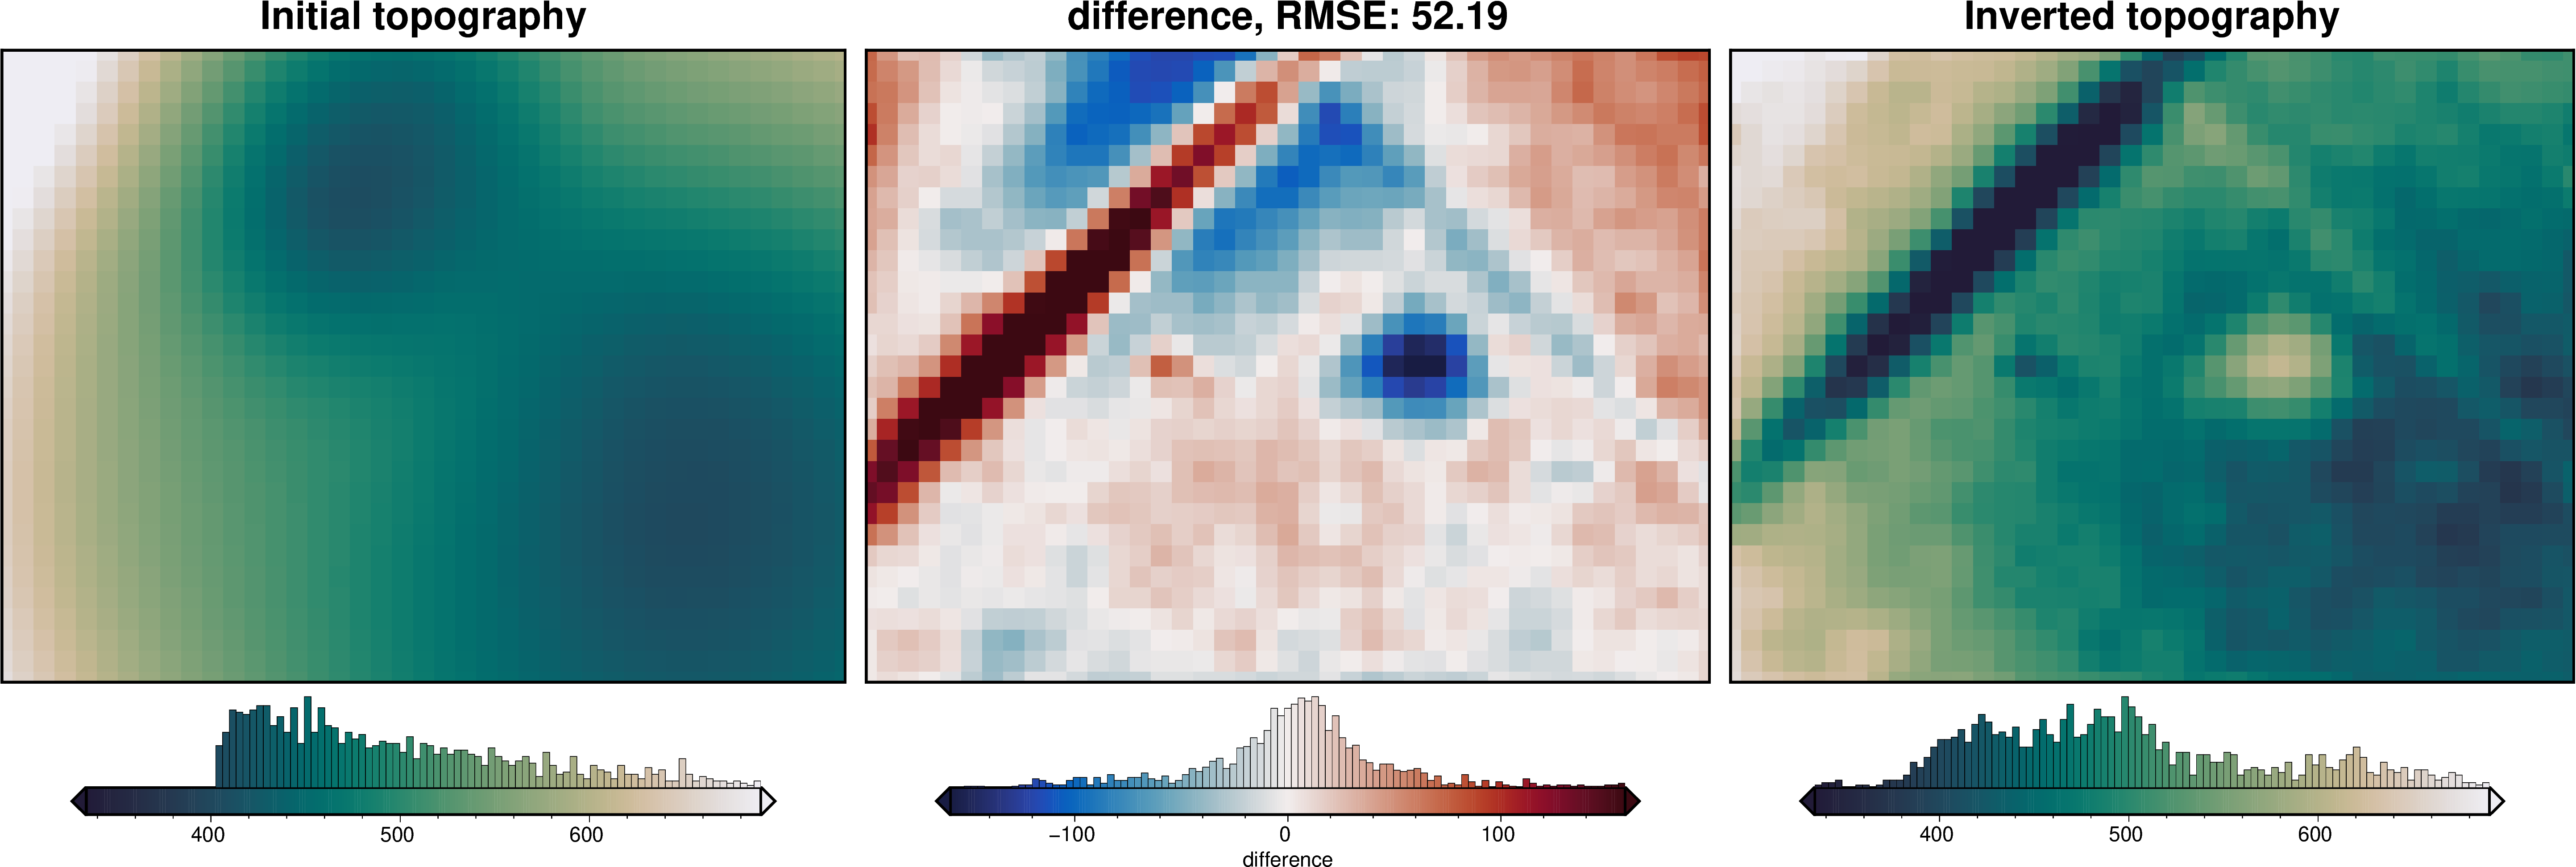

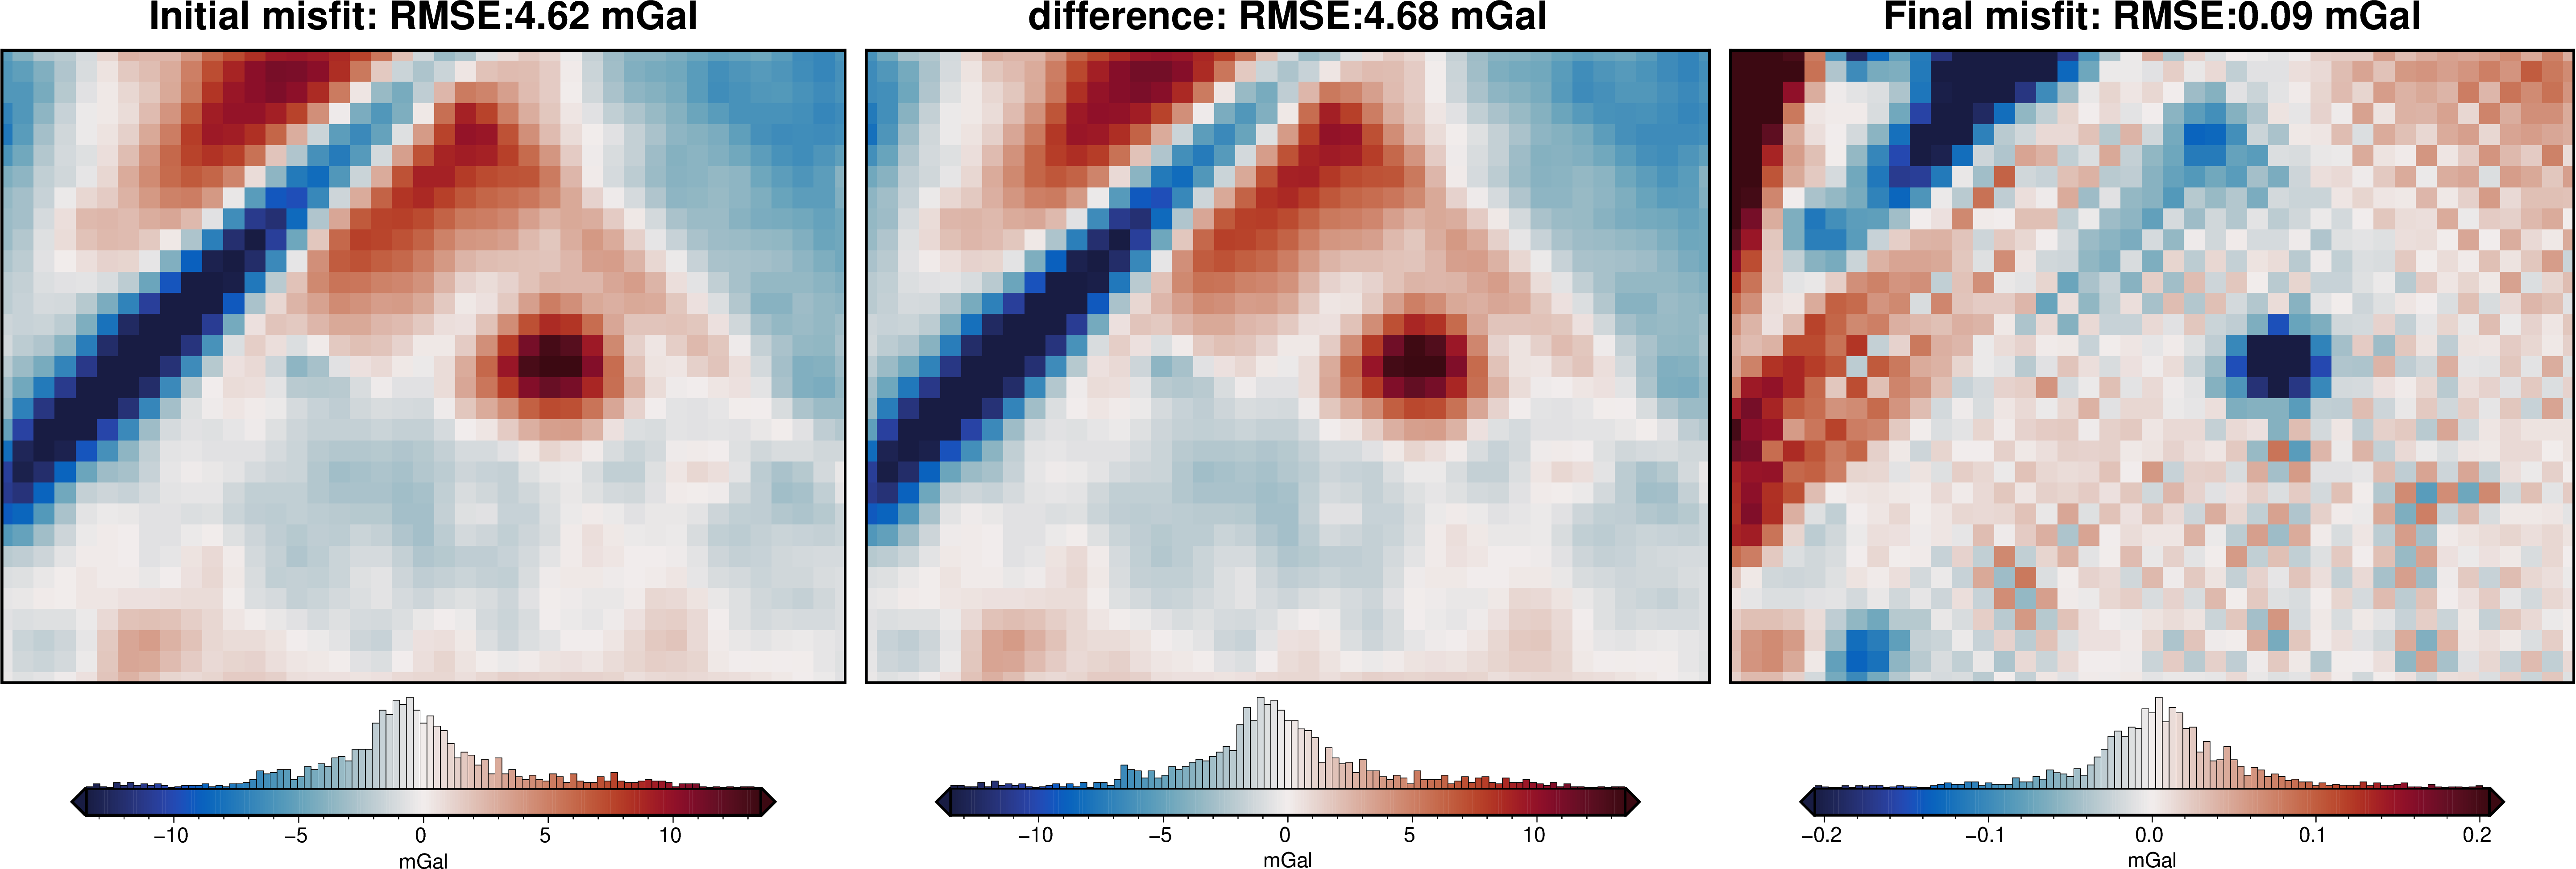

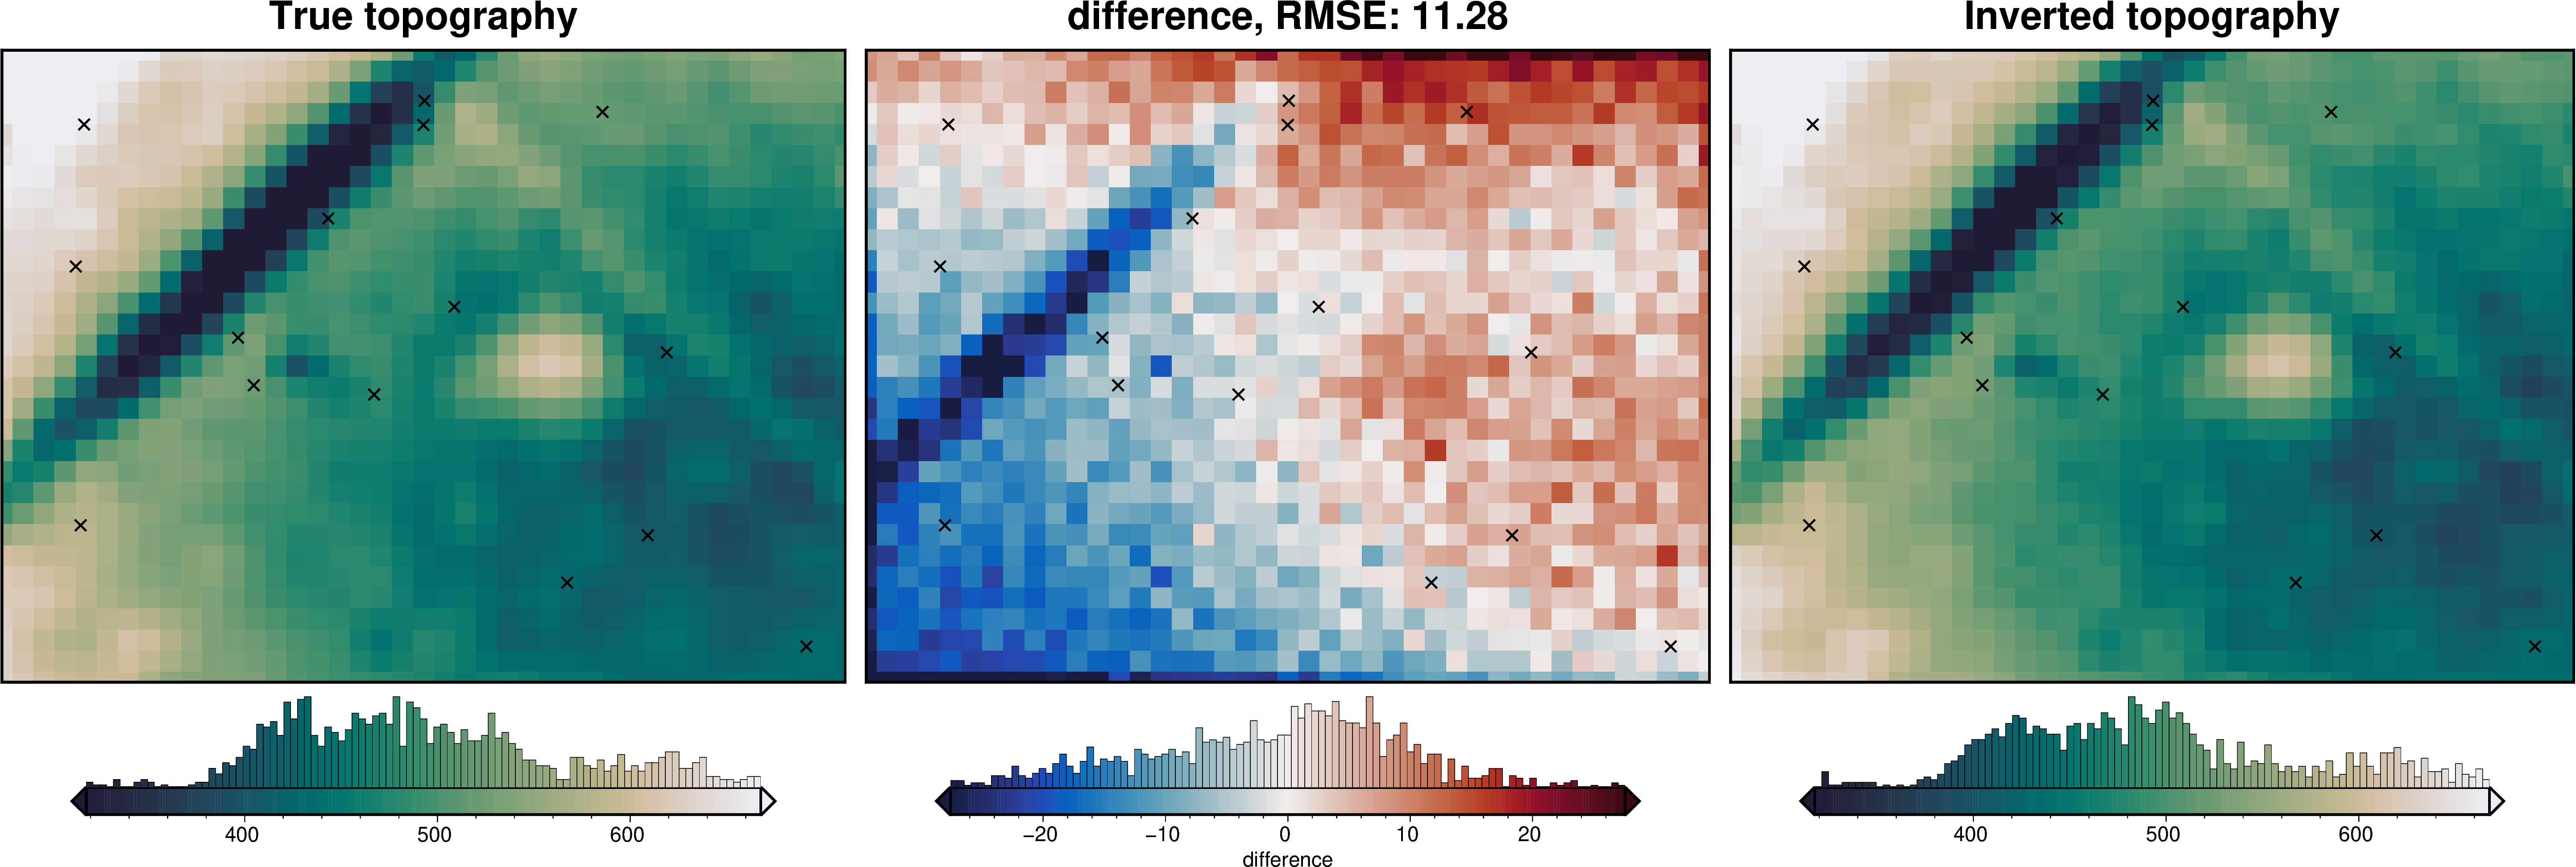

In [ ]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=False,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

# Absolute value of inversion error

plot [WARNING]: .4c, not a valid number and may not be decoded properly.


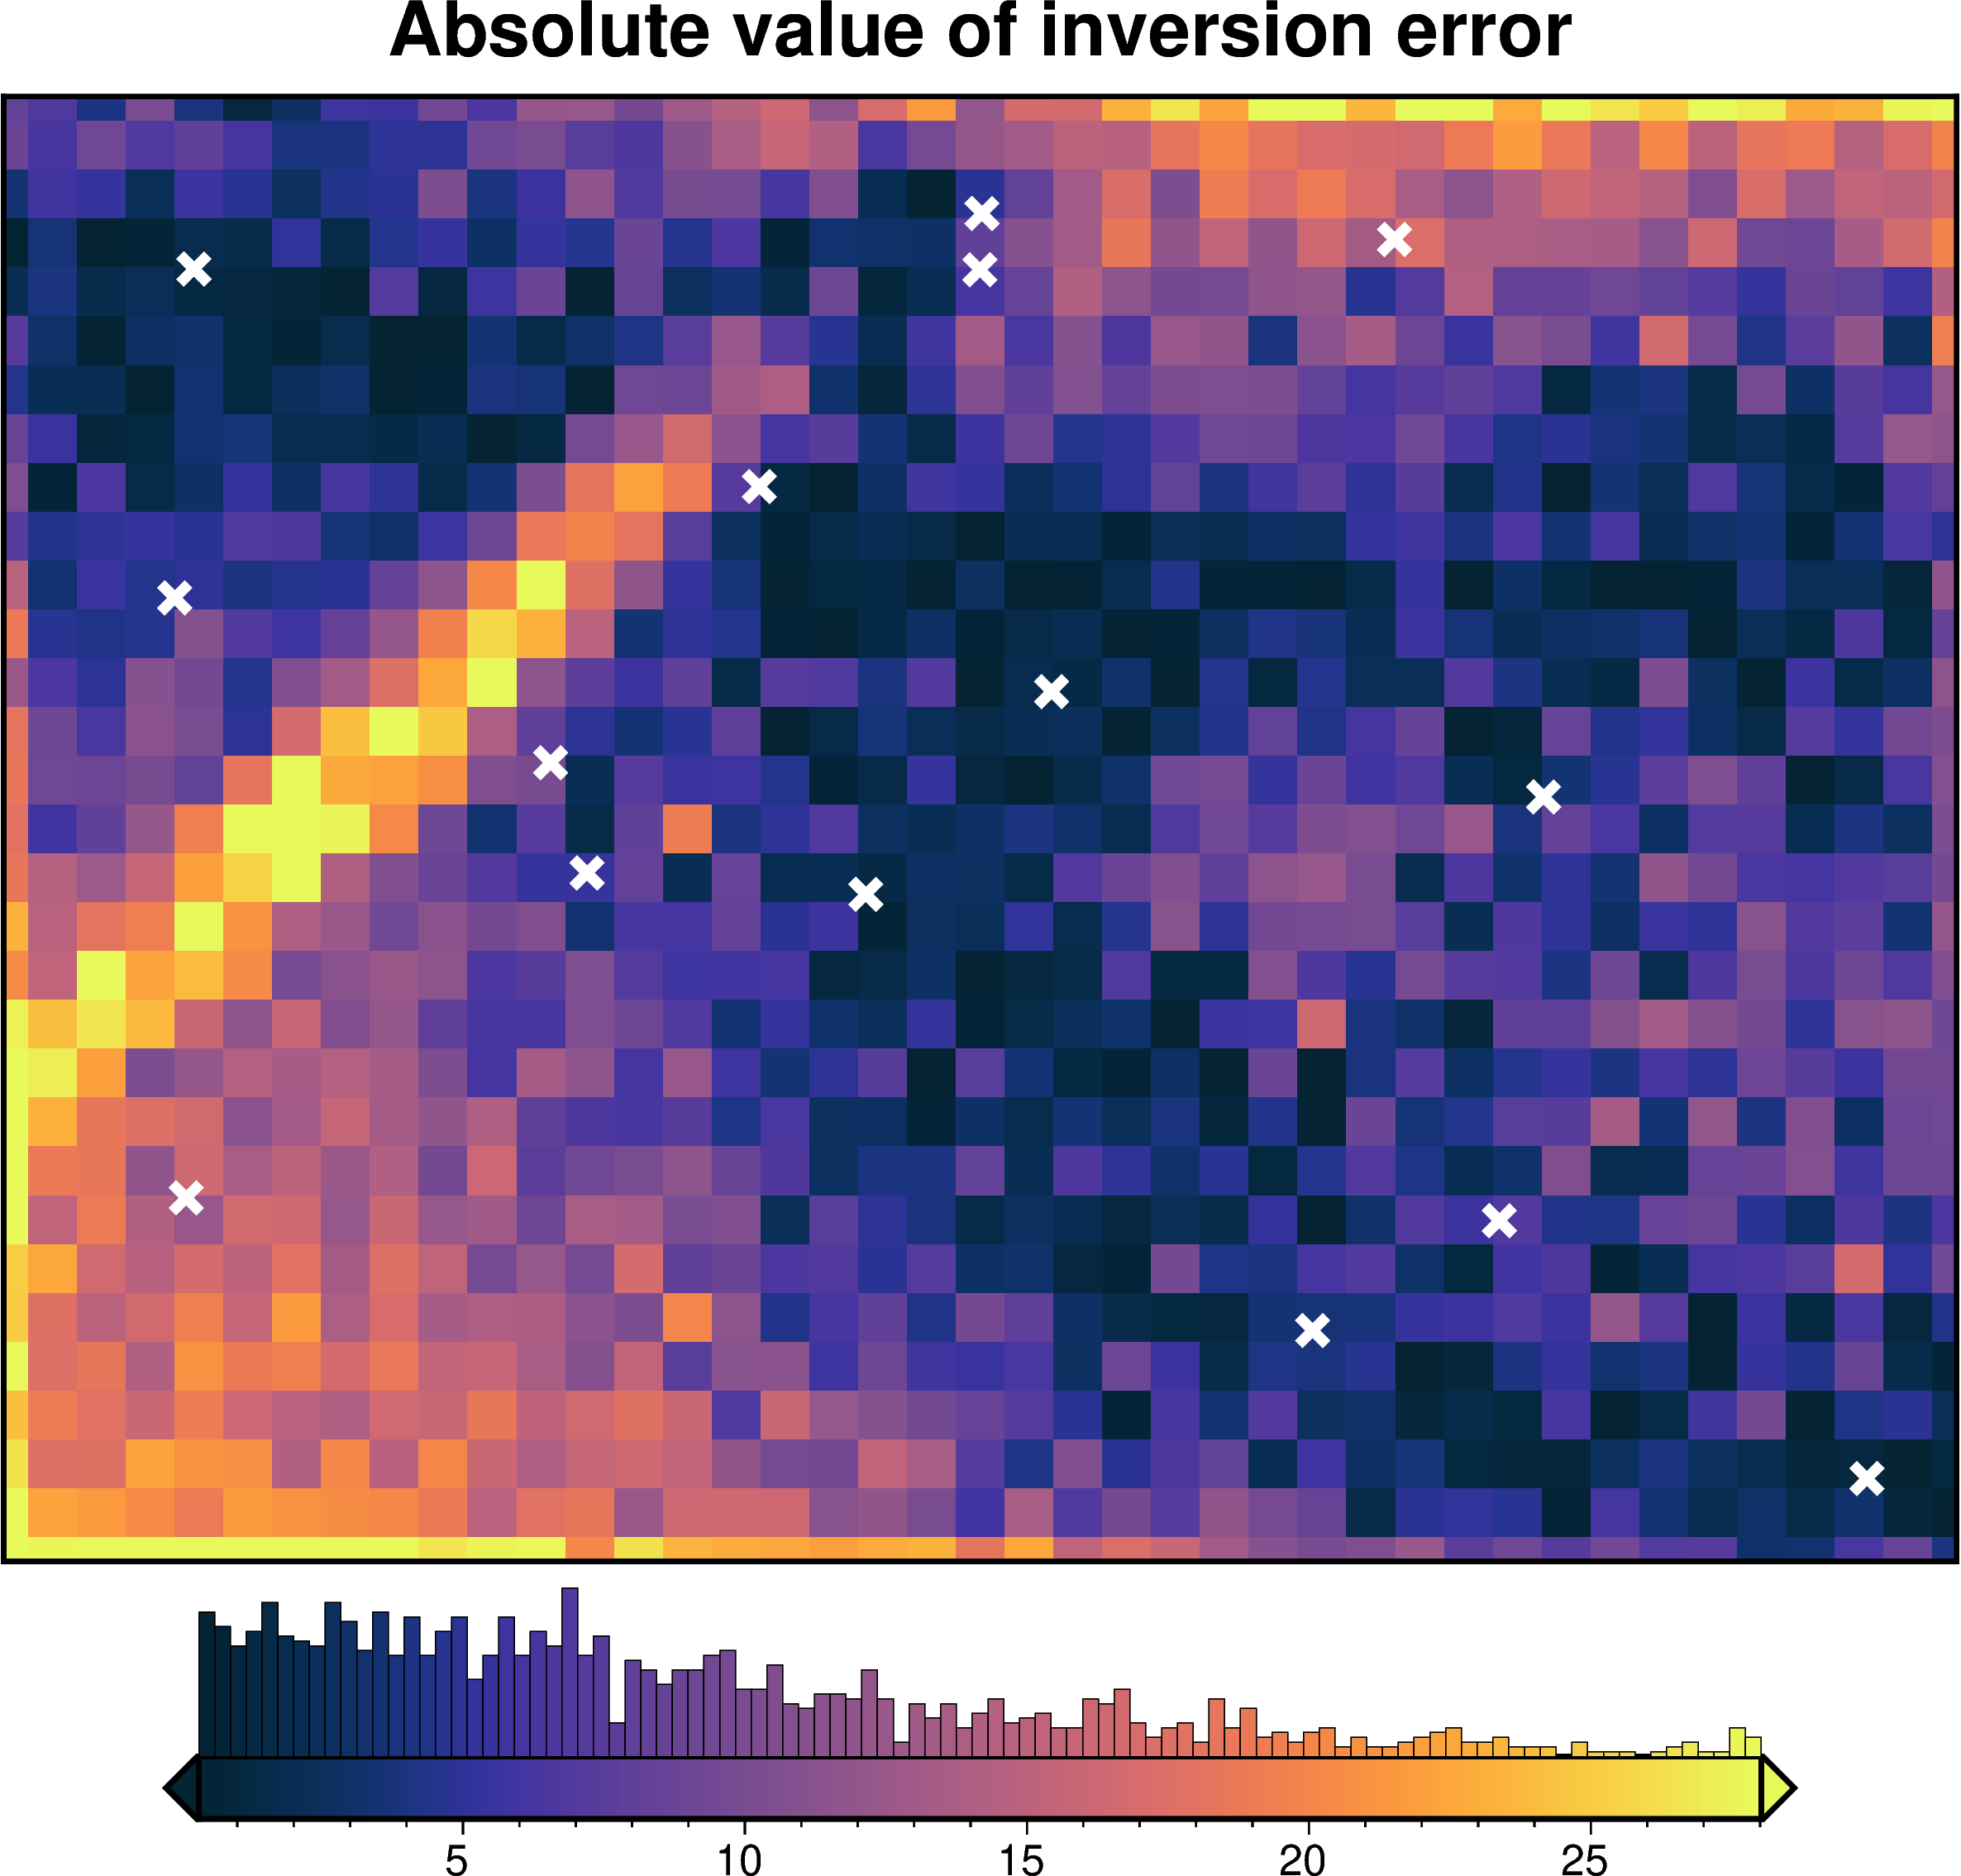

In [12]:
inversion_error = np.abs(true_topography - final_topography)
fig = maps.plot_grd(
    inversion_error,
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
    points=constraint_points,
    points_style="x.4c,",
    points_pen="3p",
    points_fill="white",
)
fig.show()

# Redo starting gravity and regional separation
use the optimal determined density contrast and zref values

In [13]:
# set the reference level from the prisms to 0
density_grid = xr.where(
    starting_topography >= zref,
    density_contrast,
    -density_contrast,
)
# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=False,
)

# regional separation
temp_reg_kwargs = copy.deepcopy(regional_grav_kwargs)

# temporarily set some kwargs
# temp_reg_kwargs["cv_kwargs"]["plot"]=True
temp_reg_kwargs["cv_kwargs"]["progressbar"] = True

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **temp_reg_kwargs,
)

grav_df["staring_res"] = grav_df.res
grav_df["starting_reg"] = grav_df.reg

grav_df.describe()

  0%|          | 0/200 [00:00<?, ?it/s]

INFO:invert4geom:Current trial (#3, {'damping': 1.612573407133368e-10}) has a worse score (-3.3888581411532597) than either of the lower (-3.3568580390225393) or upper (-0.6951917691820506) parameter value limits, it might be best to stop the study and expand the limits.
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 101
INFO:invert4geom:	parameter: {'damping': 0.03195748382073139}
INFO:invert4geom:	scores: [0.3425792543858968]


,northing,easting,upward,upper_surface_grav,lower_surface_grav,observed_grav,gravity_anomaly,uncert,starting_gravity,true_res,misfit,reg,res,staring_res,starting_reg
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.128924,0.004007,-0.124917,-0.124917,0.1,1.291839,-1.258972,-1.416756,-0.739126,-0.677630,-0.677630,-0.739126
std,8947.792584,11836.81698,0.0,7.128555,0.714063,7.271000,7.269461,0.0,7.895746,4.602393,5.186440,1.644017,4.574136,4.574136,1.644017
min,0.000000,0.00000,1001.0,-17.179165,-1.033526,-16.887669,-17.040892,0.1,-9.178955,-19.592049,-21.073109,-3.740570,-18.444515,-18.444515,-3.740570
25%,7000.000000,10000.00000,1001.0,-5.448853,-0.601914,-5.750137,-5.739415,0.1,-5.011978,-3.001264,-3.639255,-2.050330,-2.446696,-2.446696,-2.050330
50%,15000.000000,20000.00000,1001.0,-1.160222,-0.153040,-0.758131,-0.713654,0.1,-0.709894,-1.444045,-1.773919,-0.700769,-0.664604,-0.664604,-0.700769
75%,23000.000000,30000.00000,1001.0,3.675021,0.541706,3.825804,3.815224,0.1,6.245837,0.461464,0.742094,0.665742,1.222102,1.222102,0.665742
max,30000.000000,40000.00000,1001.0,19.599674,1.599823,19.781652,19.936108,0.1,26.653816,13.969991,14.922073,1.956277,14.545149,14.545149,1.956277


In [41]:
# plotting functions for uncertainty results
def uncert_plots(
    results,
    inversion_region,
    spacing,
    true_topography,
    constraint_points=None,
    weight_by=None,
):
    if (weight_by == "constraints") & (constraint_points is None):
        msg = "must provide constraint_points if weighting by constraints"
        raise ValueError(msg)

    stats_ds = uncertainty.merged_stats(
        results=results,
        plot=True,
        constraints_df=constraint_points,
        weight_by=weight_by,
        region=inversion_region,
    )

    try:
        mean = stats_ds.weighted_mean
        stdev = stats_ds.weighted_stdev
    except AttributeError:
        mean = stats_ds.z_mean
        stdev = stats_ds.z_stdev

    _ = polar_utils.grd_compare(
        true_topography,
        mean,
        region=vd.pad_region(inversion_region, -spacing),
        plot=True,
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
        points=constraint_points,
        points_style="x.3c",
    )
    _ = polar_utils.grd_compare(
        np.abs(true_topography - mean),
        stdev,
        region=vd.pad_region(inversion_region, -spacing),
        plot=True,
        grid1_name="True error",
        grid2_name="Stochastic uncertainty",
        cmap="thermal",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
        points_fill="white",
    )
    return stats_ds

# Uncertainty analysis

In [20]:
# get mean spacing between nearest constraints
mean_spacing = np.mean(
    vd.median_distance(
        (constraint_points.easting, constraint_points.northing),
        k_nearest=1,
    )
)
mean_spacing

np.float64(5599.156508868462)

In [23]:
# use optimal eq source parameters for regional separation in uncertainty analysis
# re-load the study from the saved pickle file
with pathlib.Path(f"{regional_grav_kwargs.get('cv_kwargs').get('fname')}.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)
reg_eq_damping = min(study.best_trials, key=lambda t: t.values[0]).params["damping"]

reg_eq_depth = 4.5 * mean_spacing

new_regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraint_points,
    damping=reg_eq_damping,
    depth=reg_eq_depth,
    block_size=None,
)
reg_eq_damping, reg_eq_depth

(0.03195748382073139, np.float64(25196.204289908077))

In [27]:
# add best damping parameter to kwargs
kwargs["solver_damping"] = solver_damping

# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    density_contrast=density_contrast,
    zref=zref,
    starting_prisms=starting_prisms,
    starting_topography=starting_topography,
    regional_grav_kwargs=new_regional_grav_kwargs,
    **kwargs,
)

## Solver damping component
To estimate the uncertainty of the choice of solver damping value, we will load the damping cross validation and calculate the standard deviation of the trials (excluding outliers)

In [31]:
# load study
with pathlib.Path("tmp/combining_it_all_damping_CV_study.pickle").open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe().drop(columns=["user_attrs_results"])
study_df.sort_values("value", inplace=True)  # noqa: PD002

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

# pick damping standard deviation based on optimization
stdev = np.log10(study_df2.params_damping).std()
print(f"calculated stdev: {stdev}")
# stdev = .1
print(f"using stdev: {stdev}")

calculated stdev: 0.473439695891782
using stdev: 0.473439695891782


best: 0.021017217578137074 
std: 0.473439695891782 
+1std: 0.06251941651066213 
-1std: 0.007065379995211915


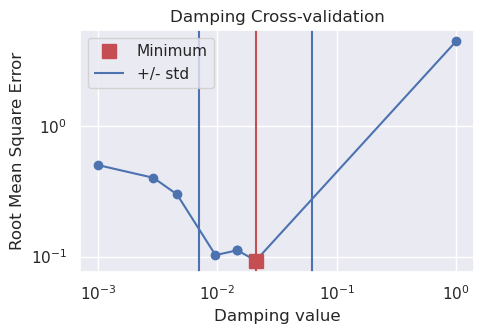

In [32]:
fig = plotting.plot_cv_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)
ax = fig.axes[0]

best = float(study_df2.params_damping.iloc[0])
upper = float(10 ** (np.log10(best) + stdev))
lower = float(10 ** (np.log10(best) - stdev))

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

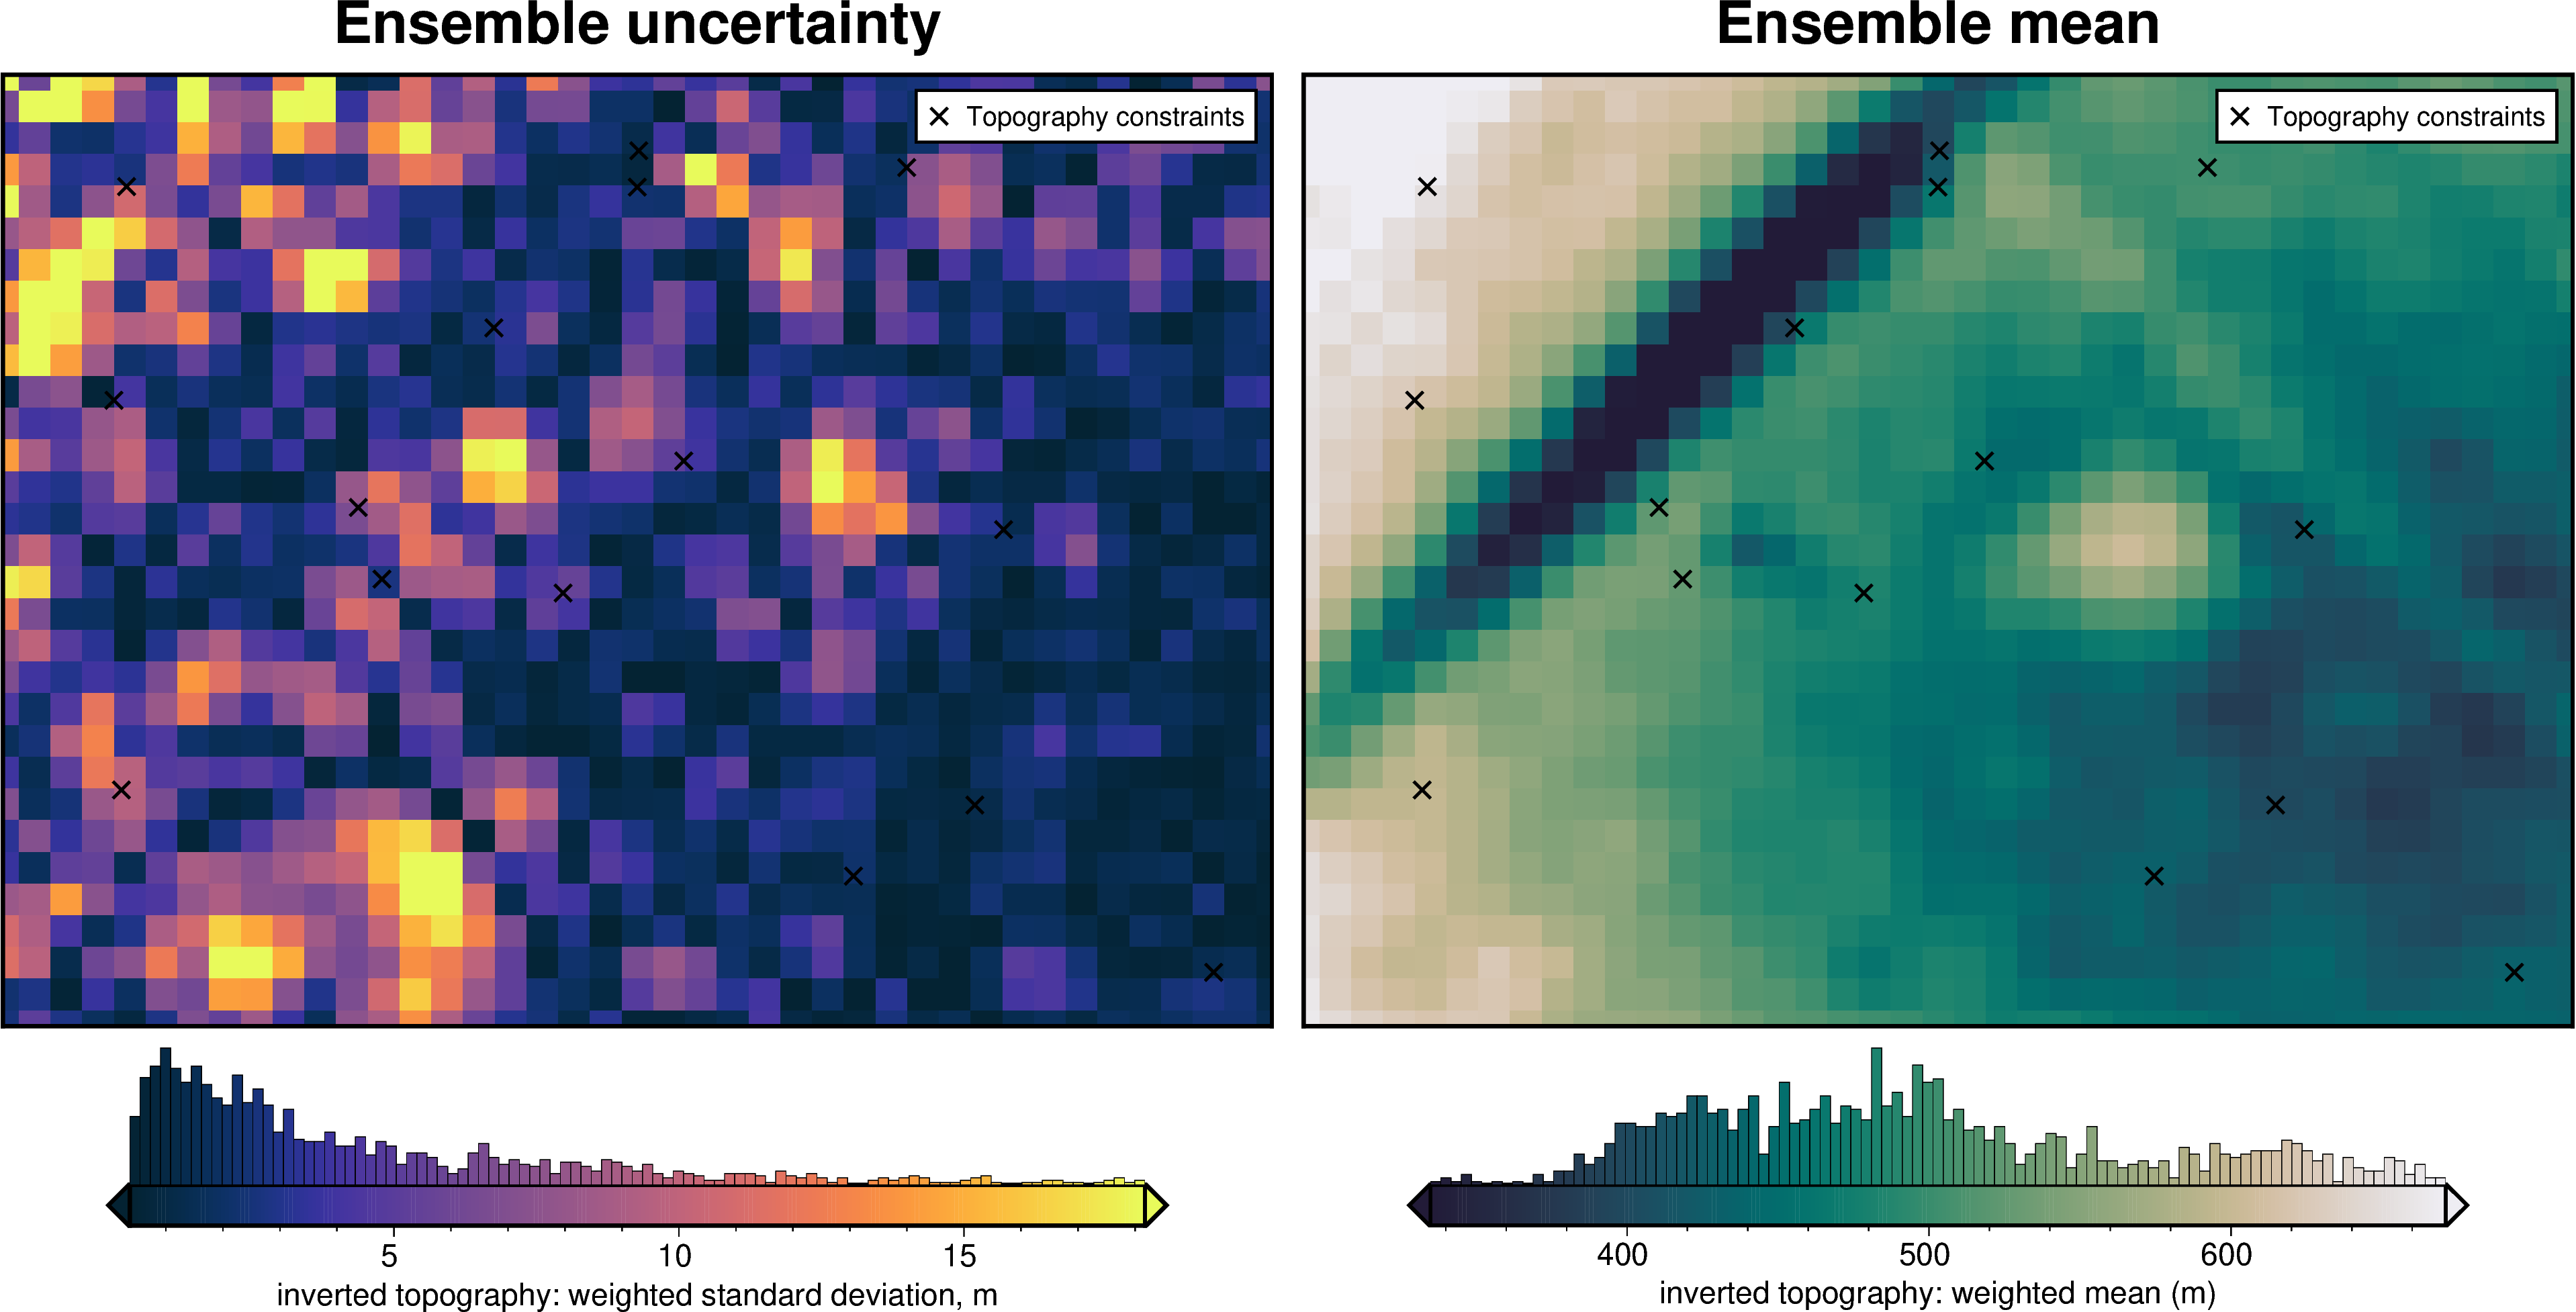

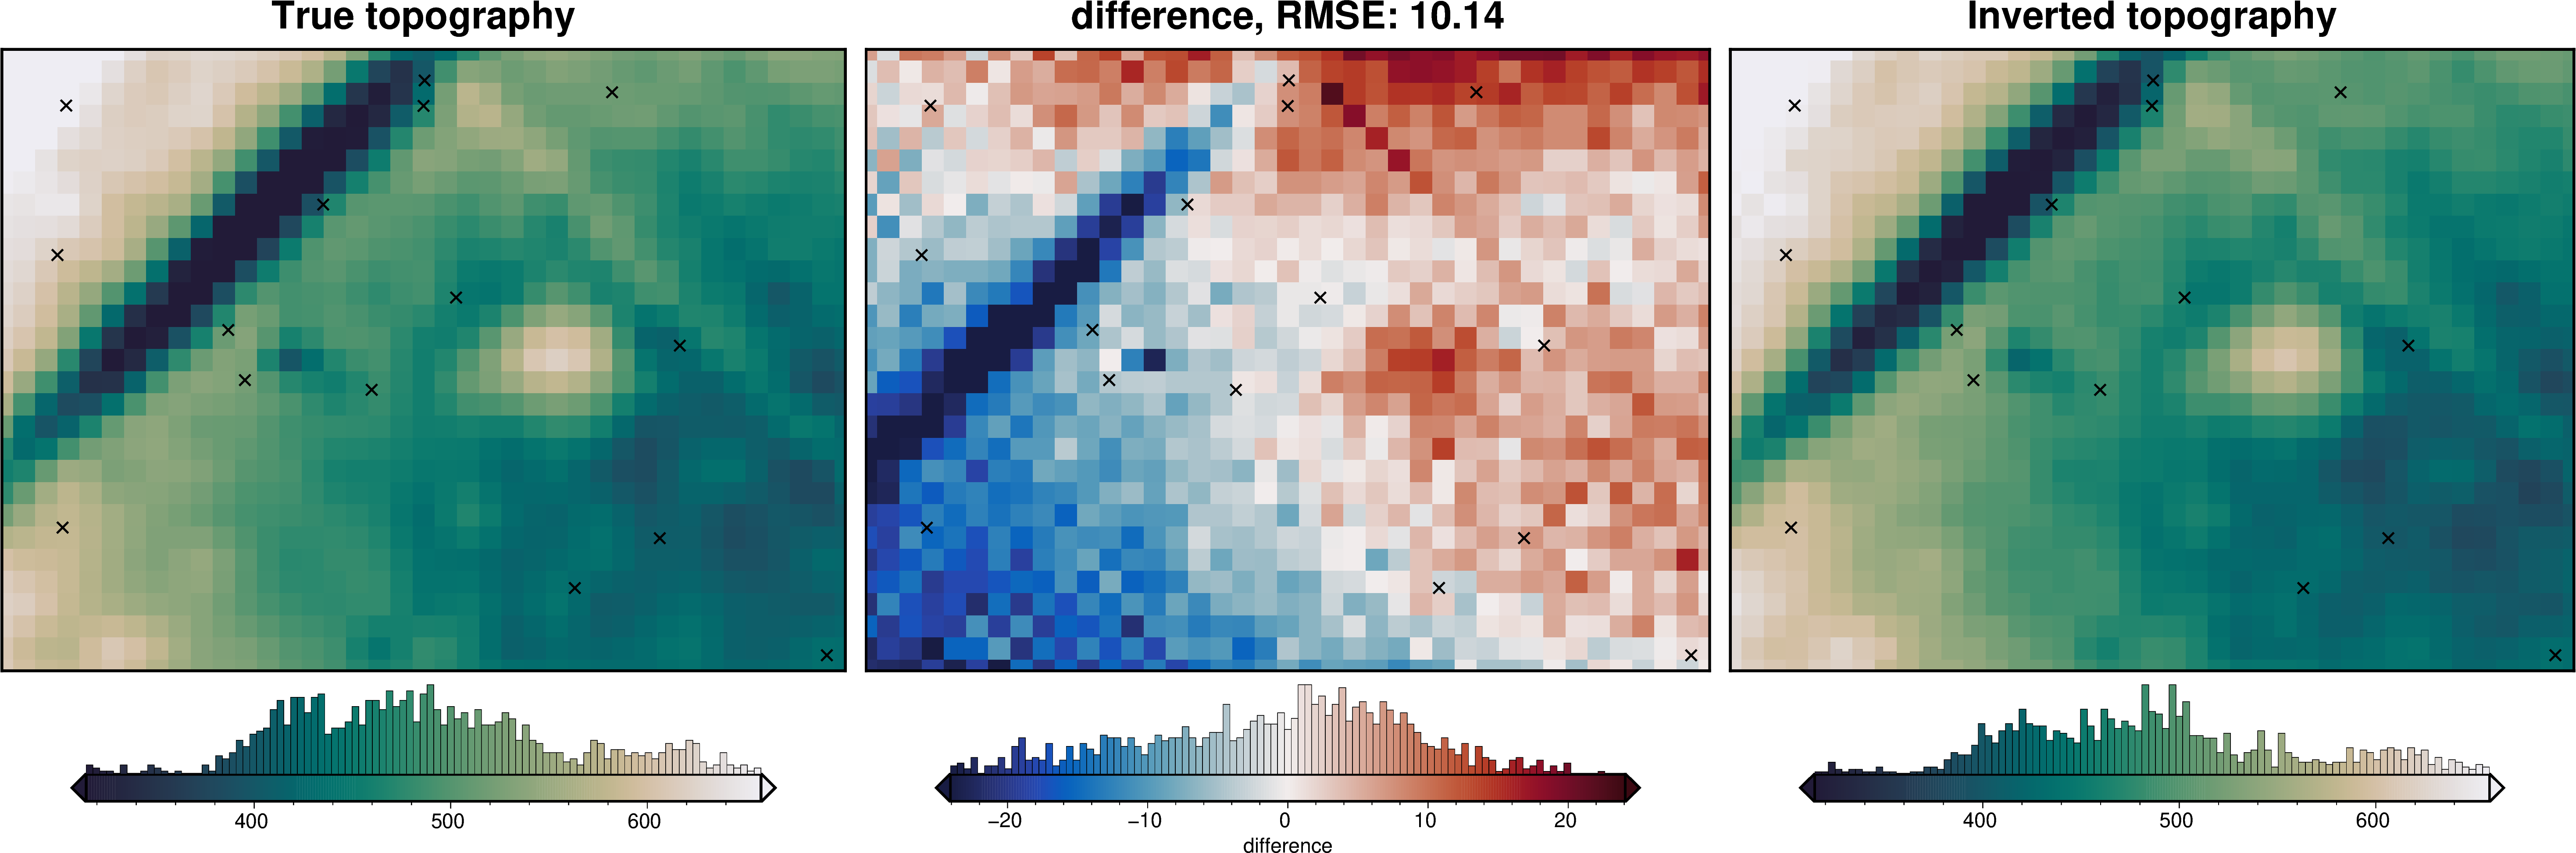

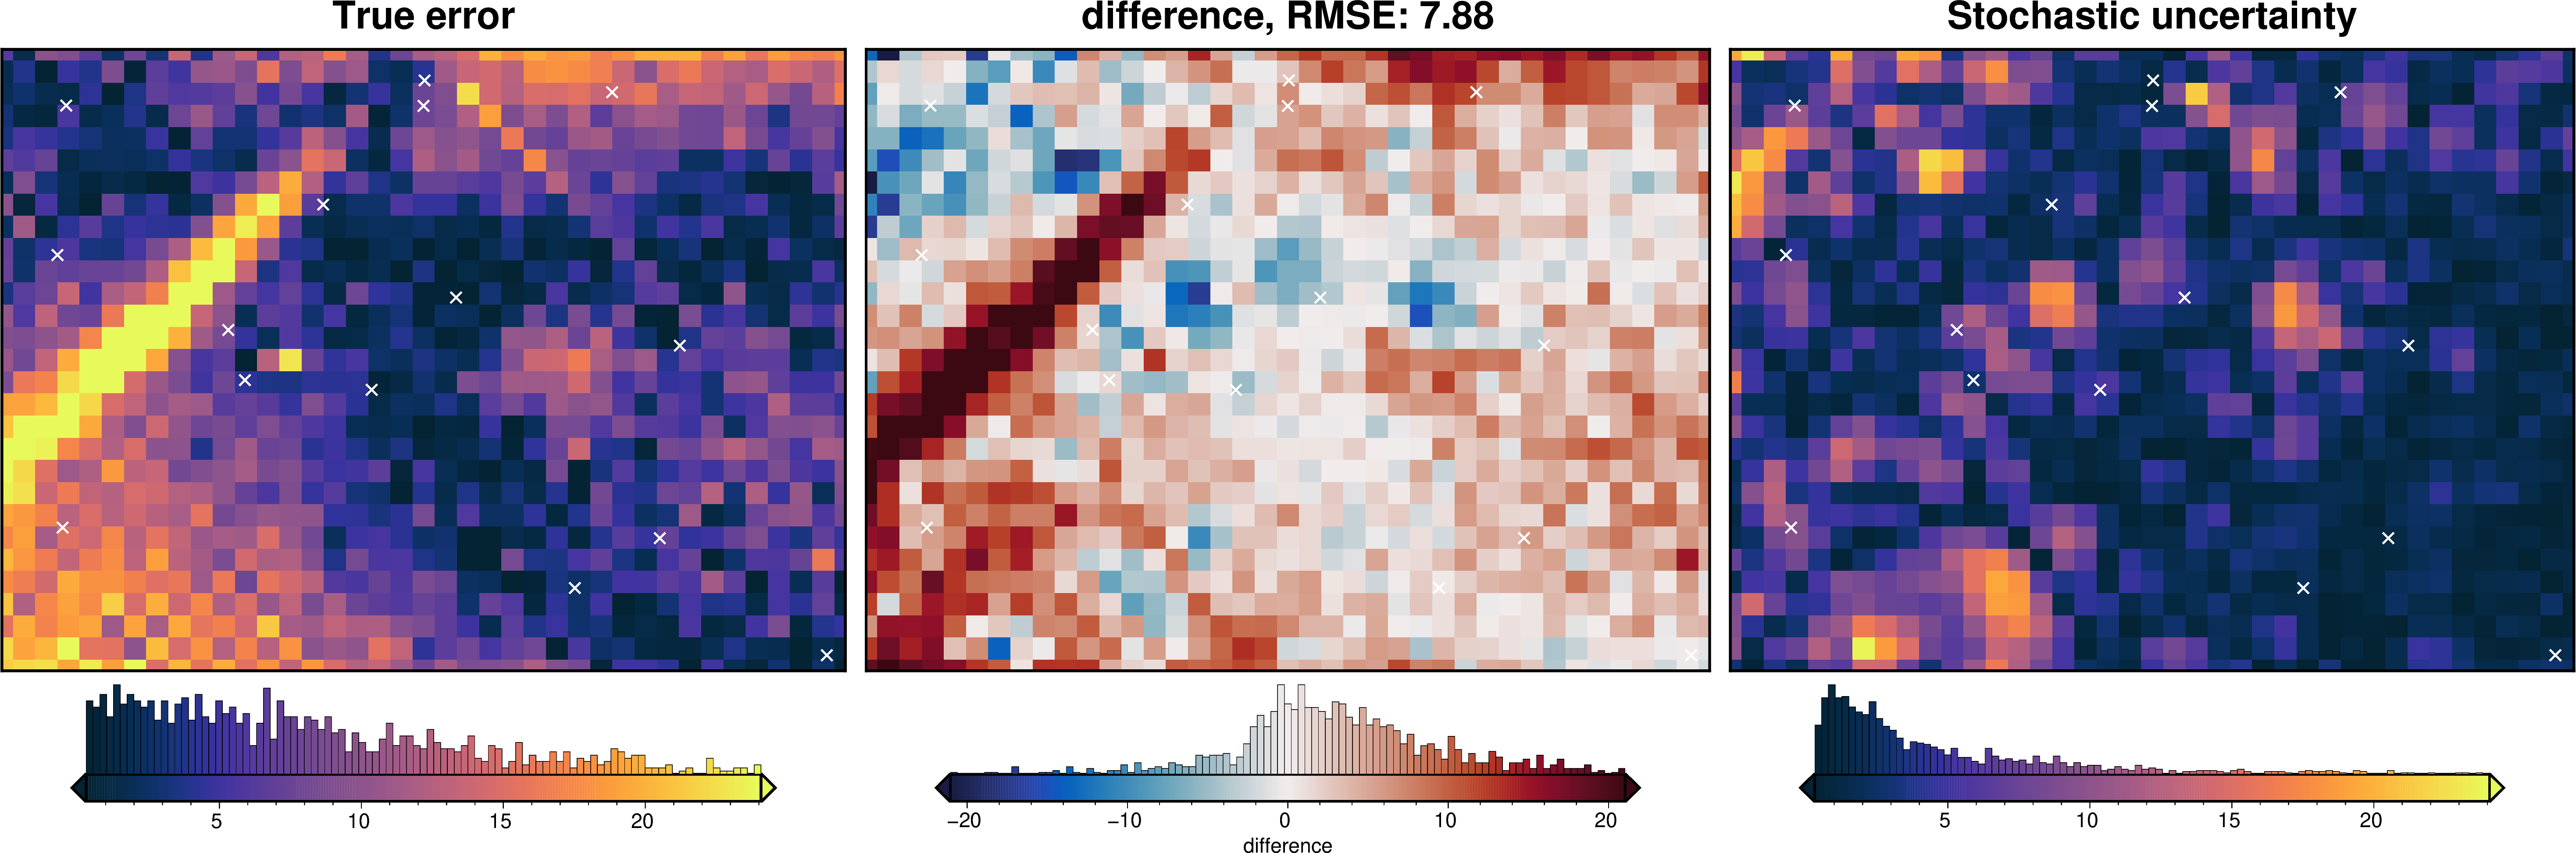

In [42]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(solver_damping),  # mean of base 10 exponent
        "scale": stdev,  # standard deviation of base 10 exponent
        "log": True,
    },
}
fname = "tmp/uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=solver_dict,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_damping_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Density component
To estimate the uncertainty of the choice of density value, we will load the density estimation optimization and calculate the standard deviation of the trials (excluding outliers)

In [44]:
# load study
with pathlib.Path("tmp/combining_it_all_density_cv_with_cpm_kfolds_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

study_df = study.trials_dataframe()
study_df.sort_values("value", inplace=True)  # noqa: PD002

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

stdev = study_df2.params_density_contrast.std()
print(f"calculated stdev: {stdev}")

# manually pick a stdev
print(f"using stdev: {stdev}")

calculated stdev: 169.53167981196884
using stdev: 169.53167981196884


best: 2857.9296283003237 
std: 169.53167981196884 
+1std: 3027.4613081122925 
-1std: 2688.397948488355


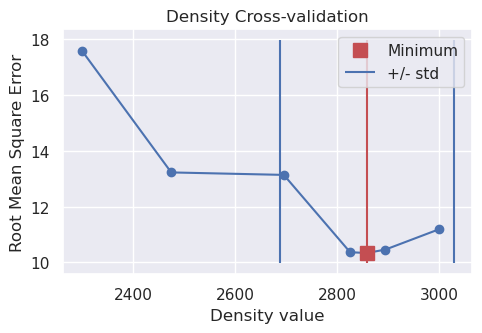

In [45]:
fig = plotting.plot_cv_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_density_contrast.values,
    param_name="Density",
    logx=False,
    logy=False,
)
ax = fig.axes[0]

best = study_df2.params_density_contrast.iloc[0]
upper = best + stdev
lower = best - stdev

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 2857.9296282999994, min: 2579.0748298781073, max: 3136.7844267218925
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_density' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: 'tmp/uncertainty_density'



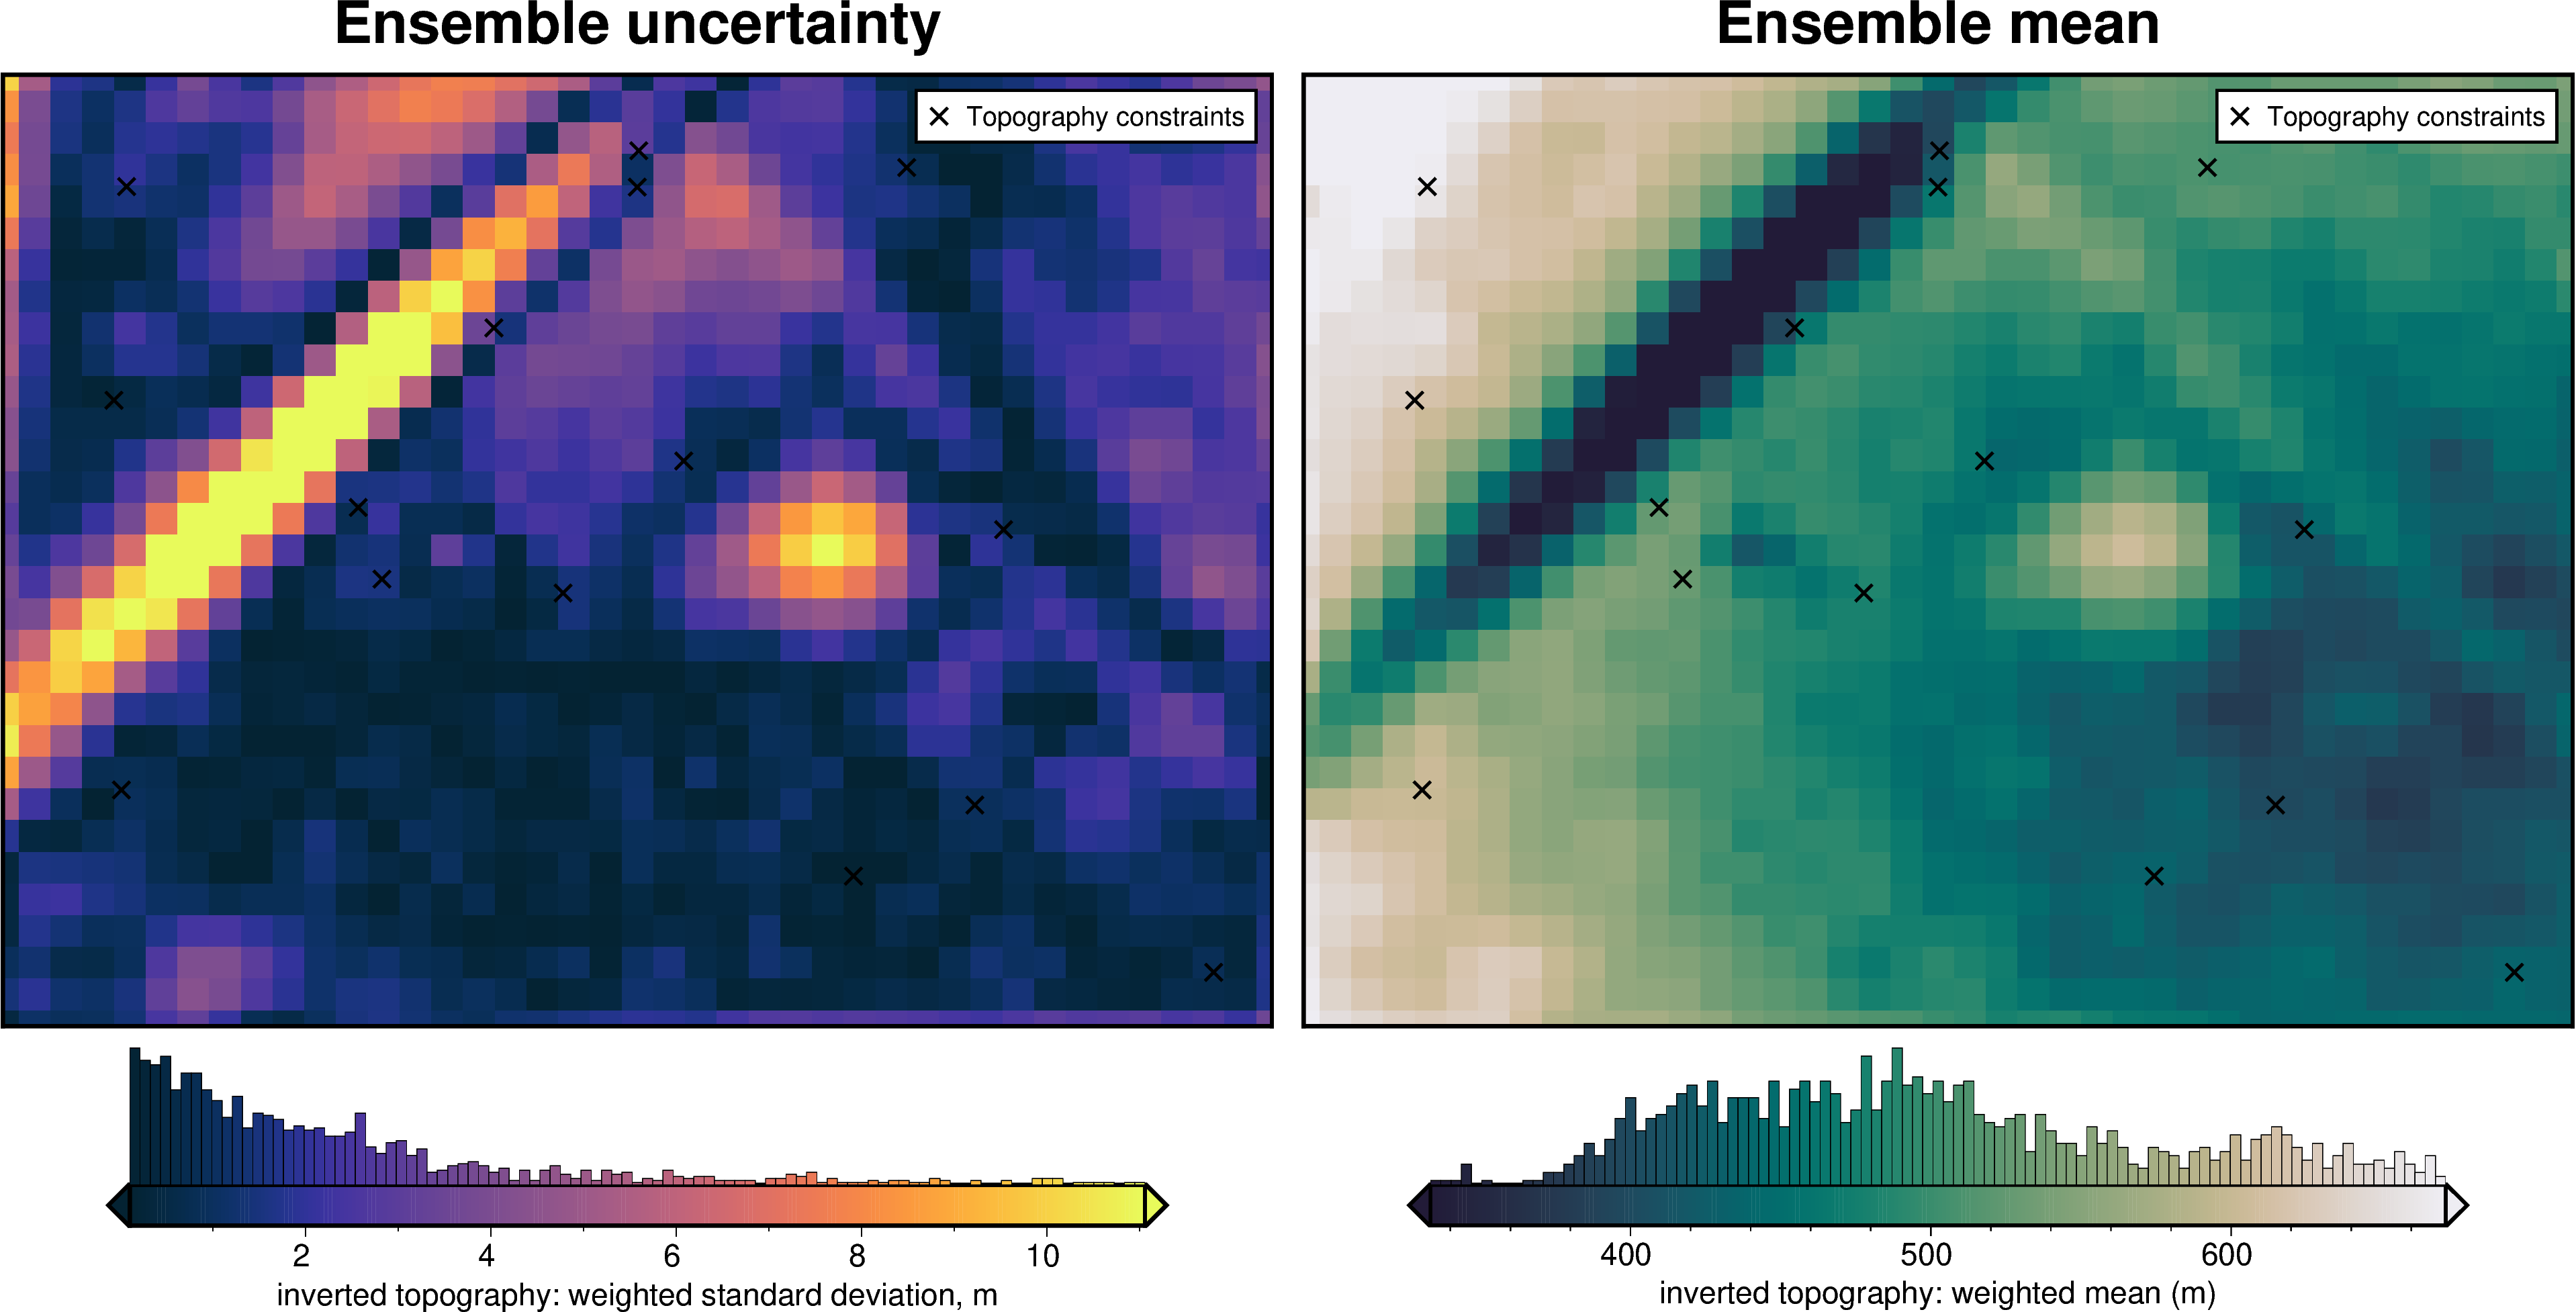

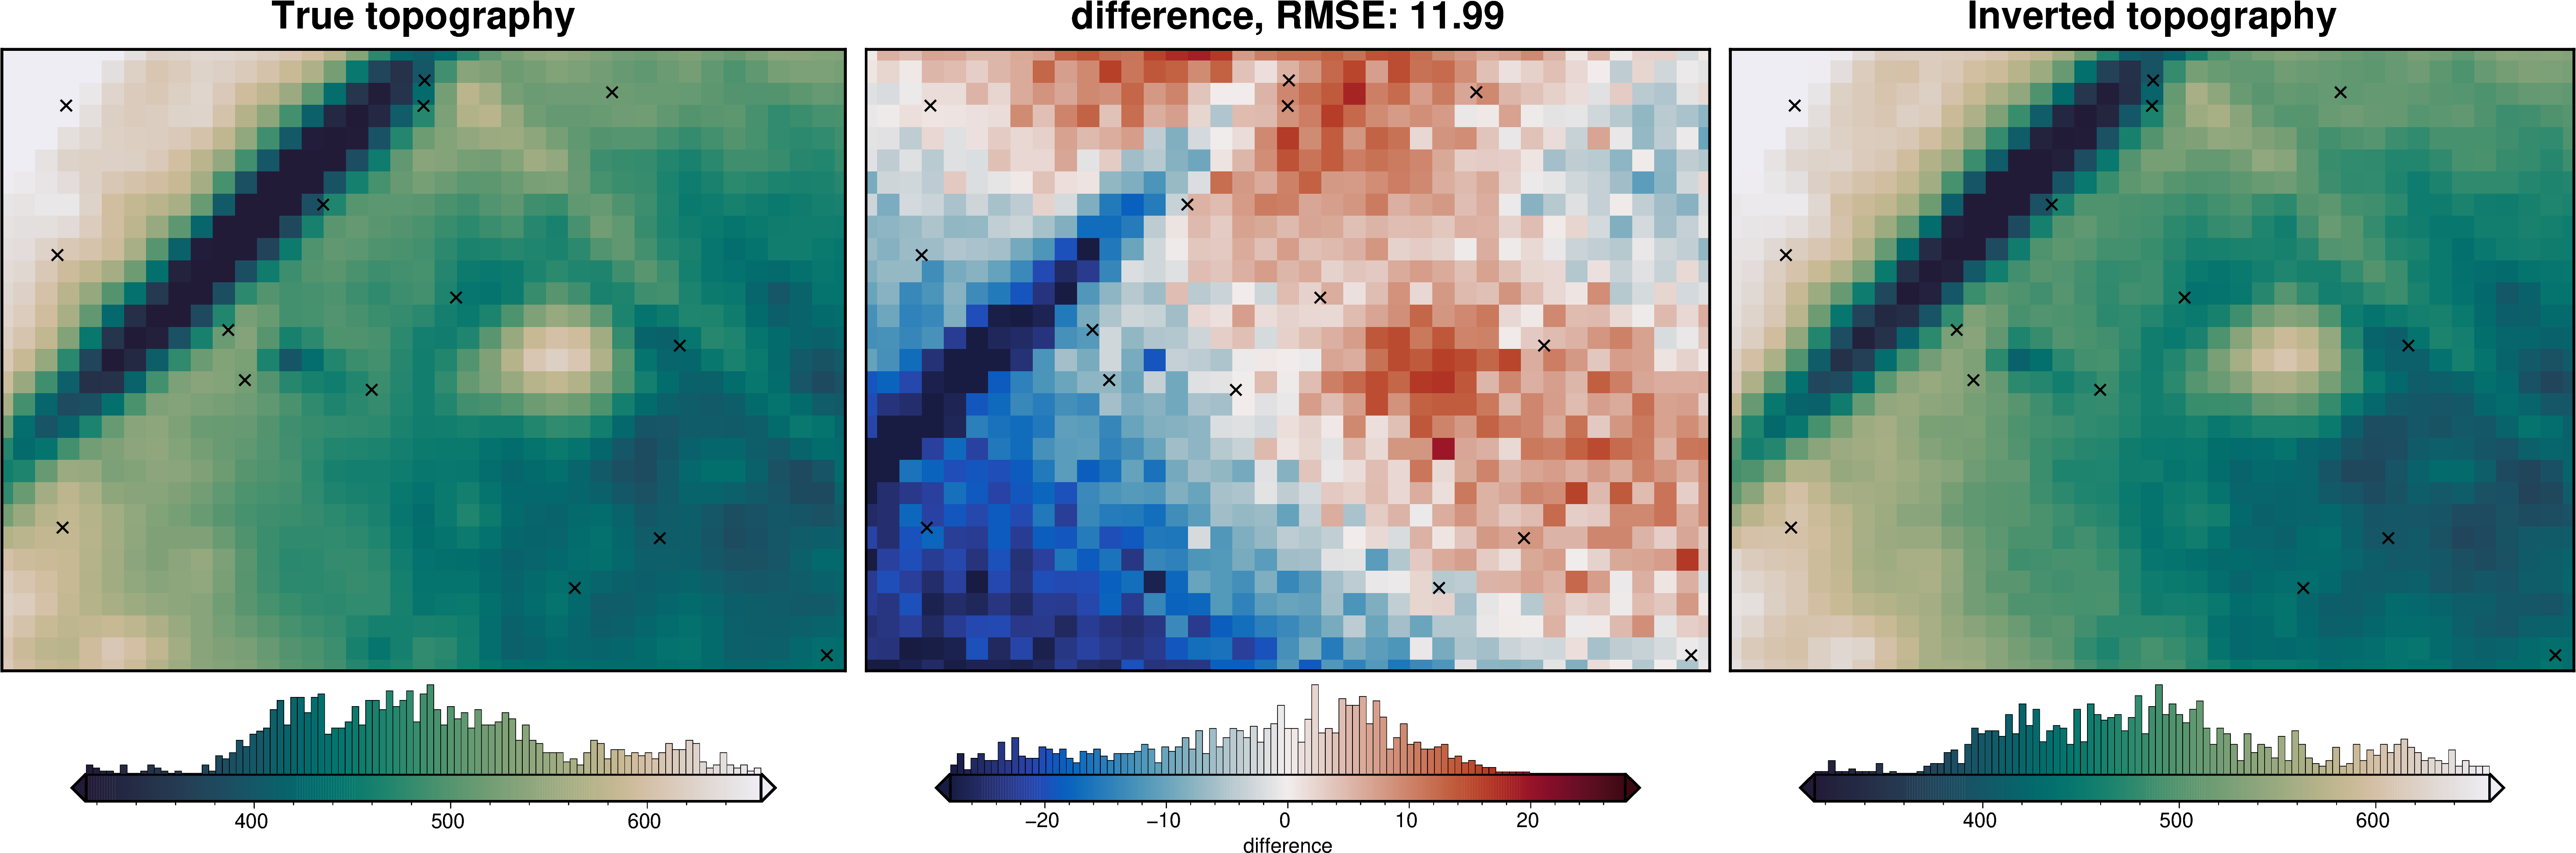

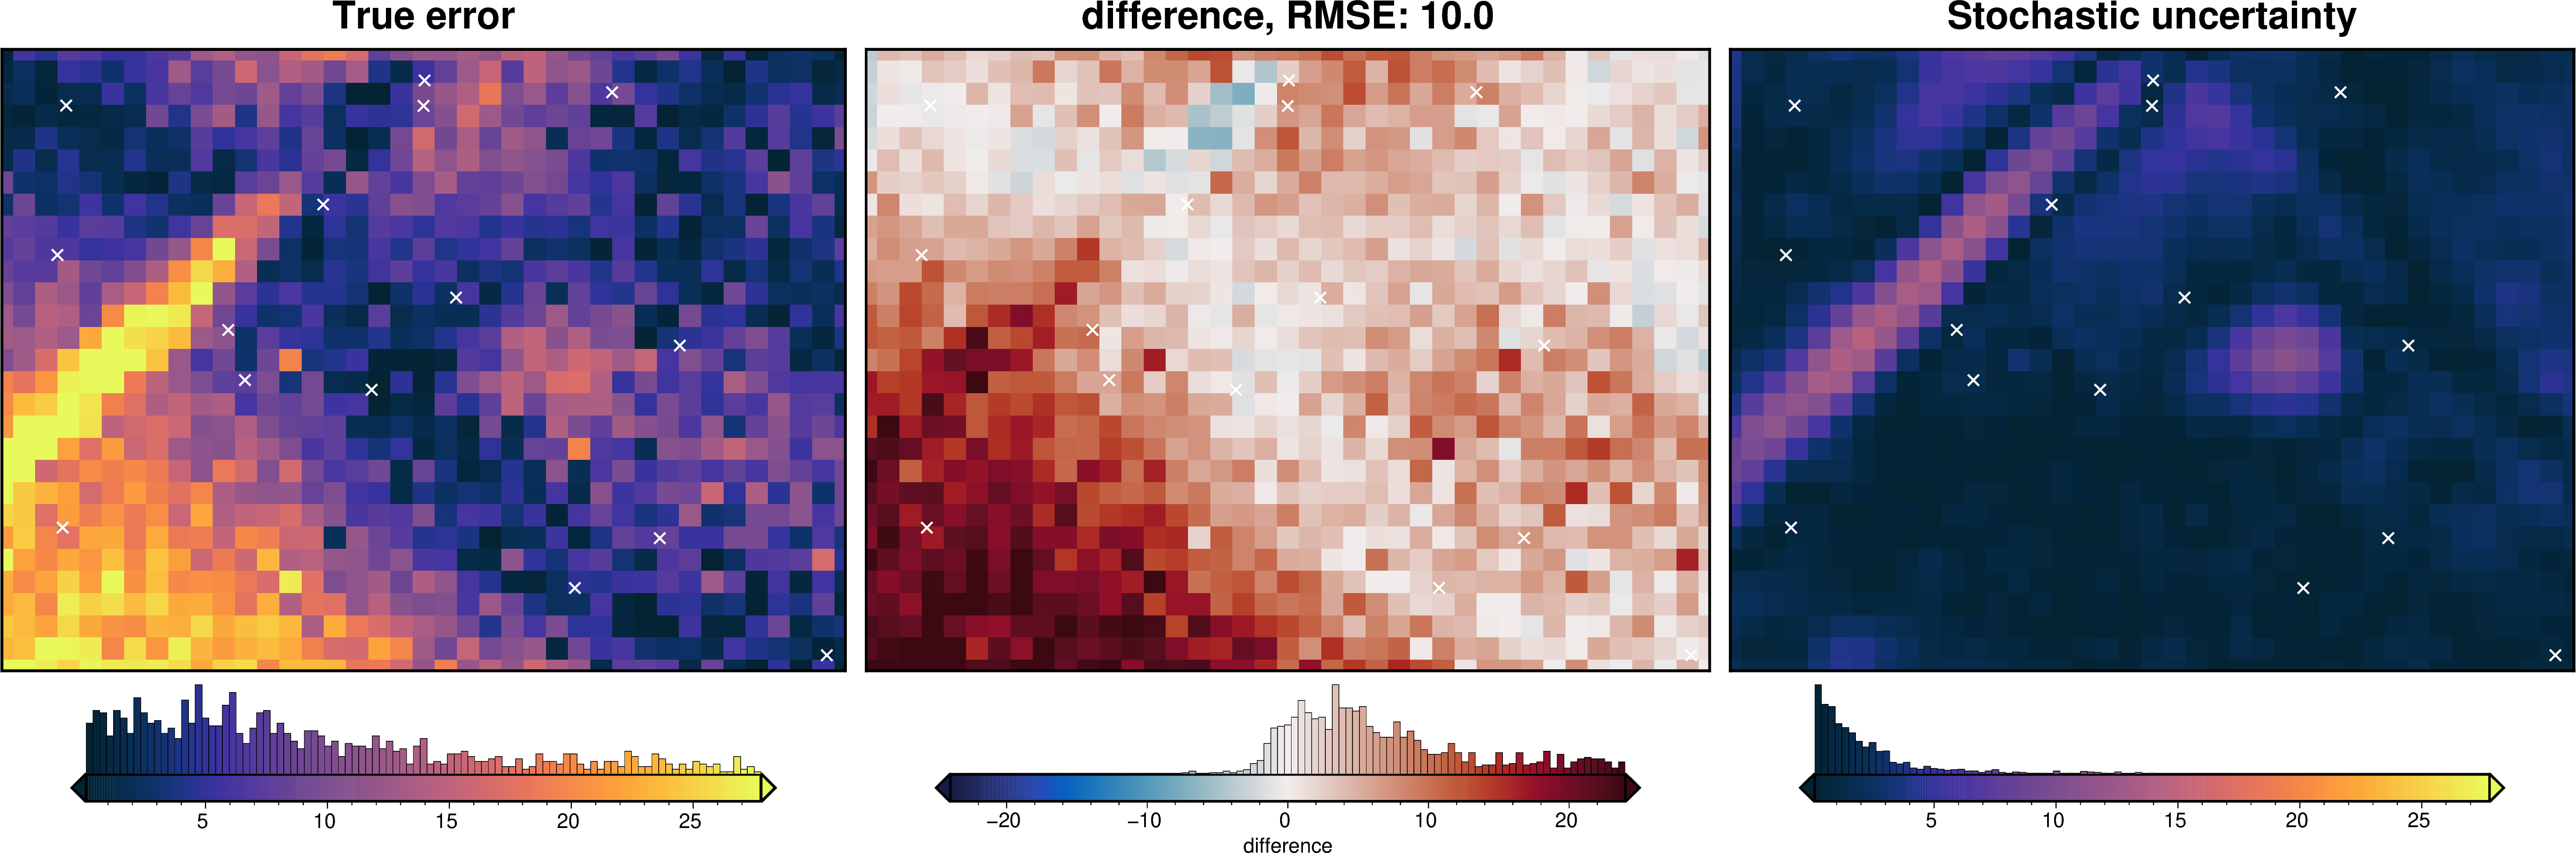

In [46]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": density_contrast,
        "scale": stdev,
    },
}
fname = "tmp/uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=density_dict,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_density_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Constraints component

INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_constraints' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: 'tmp/uncertainty_constraints'



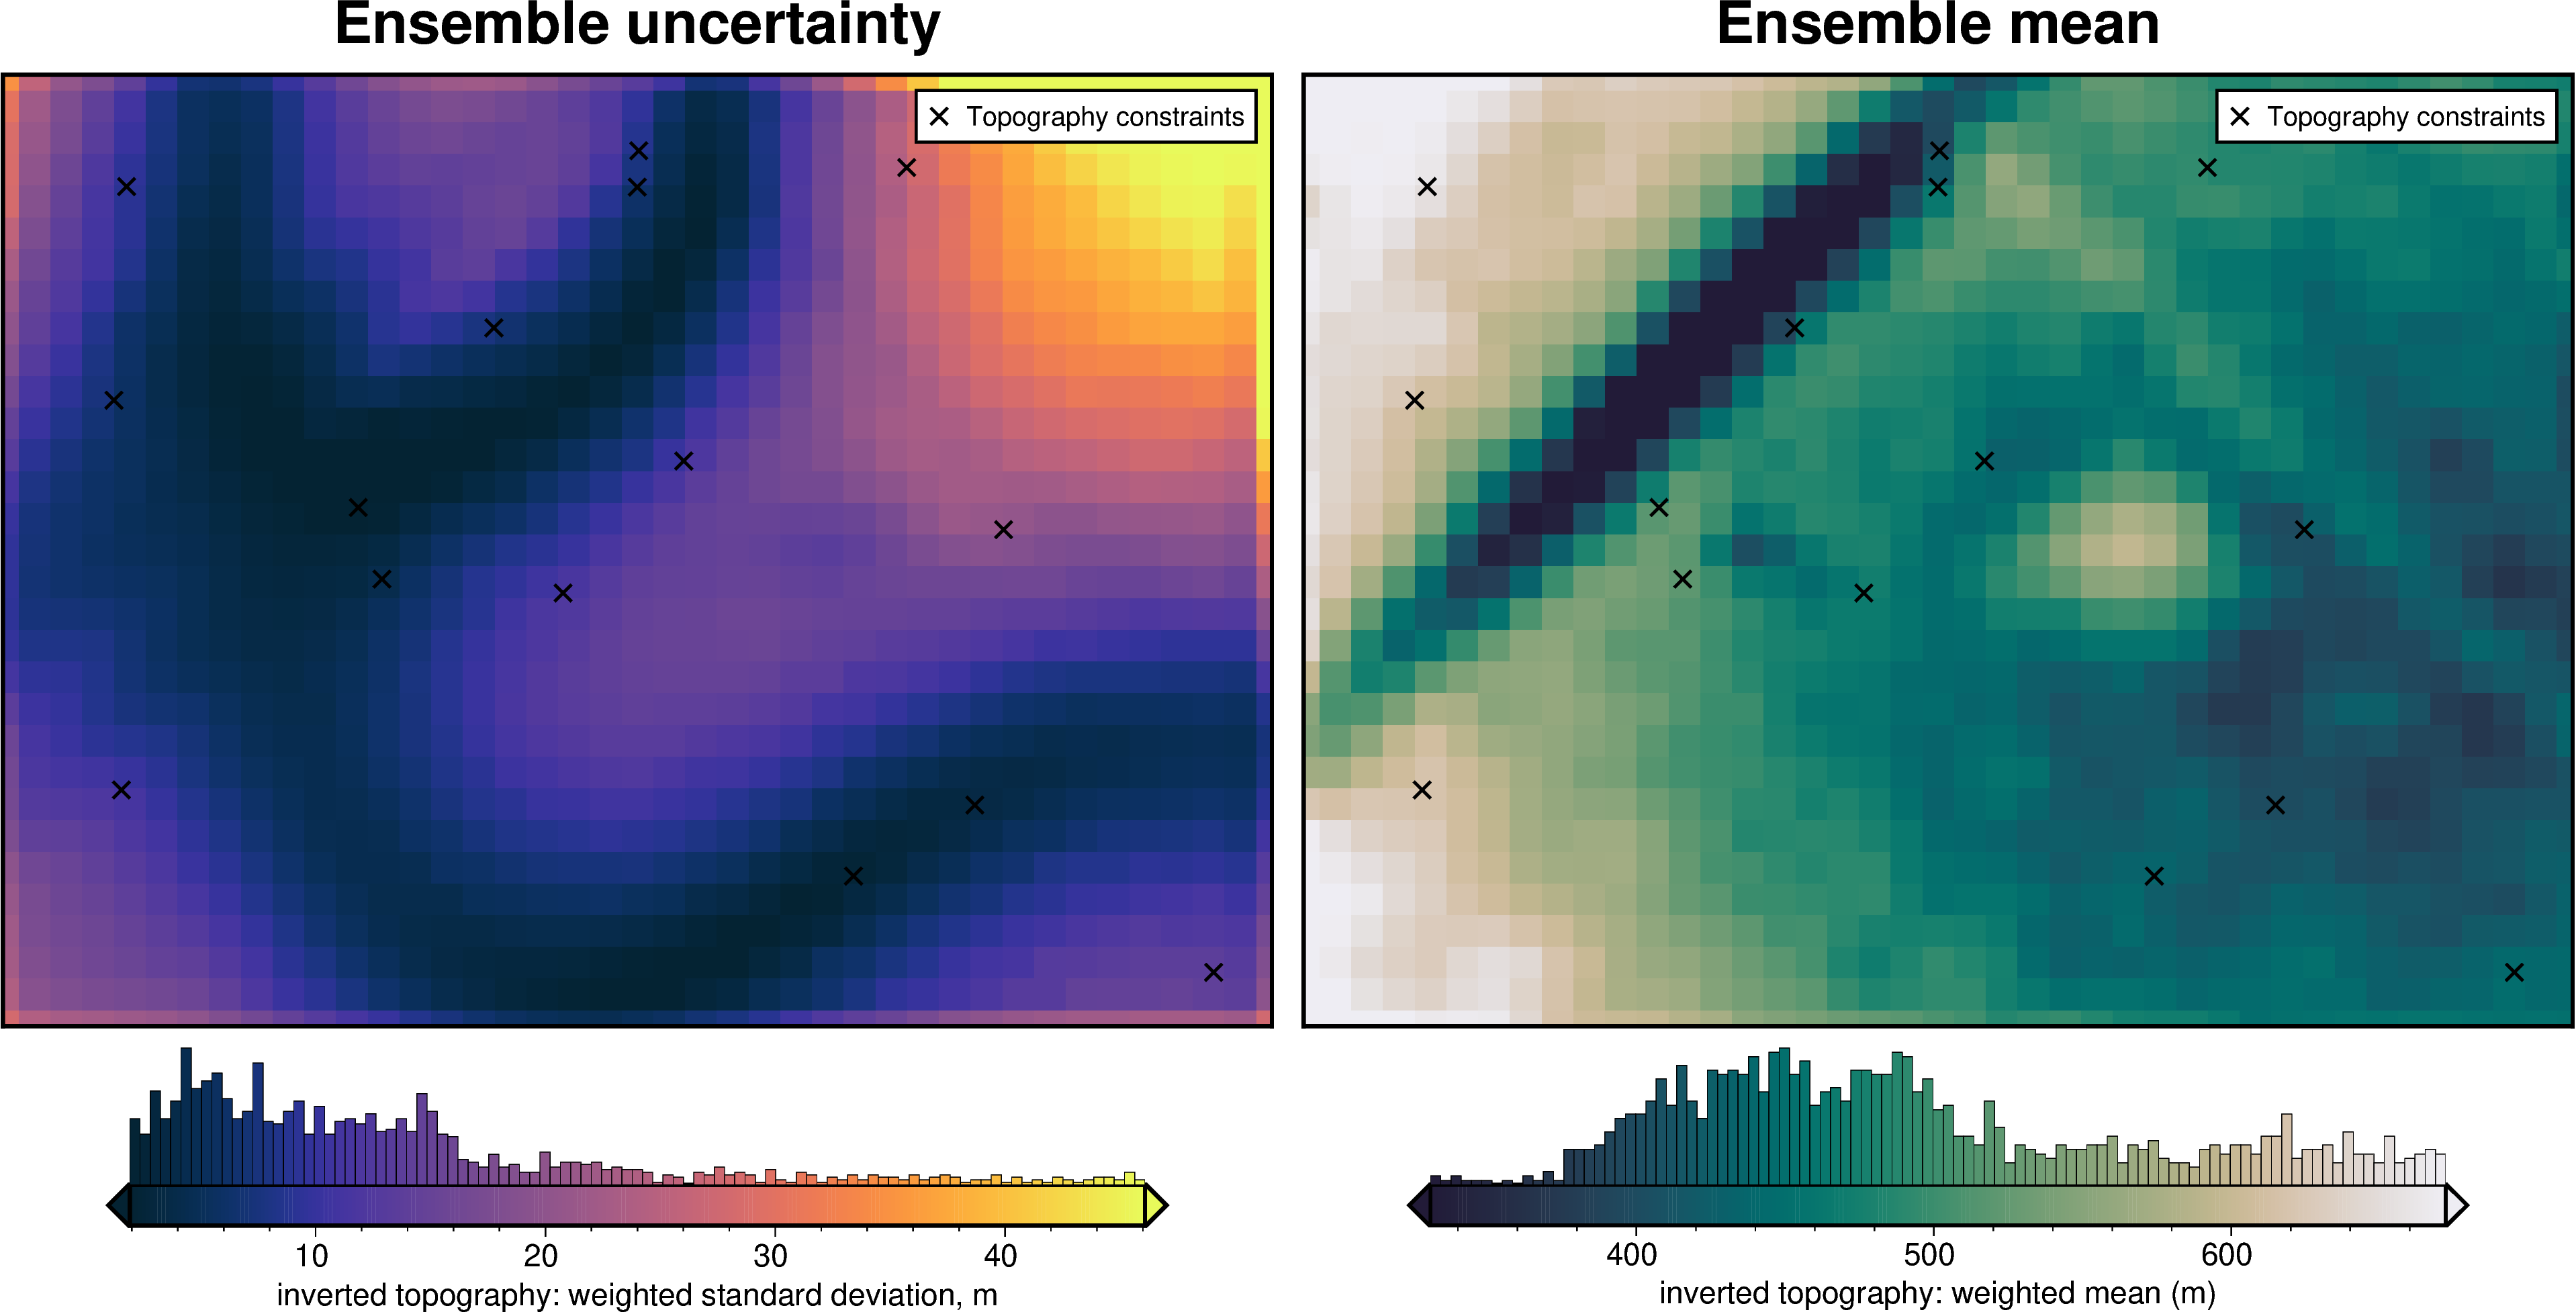

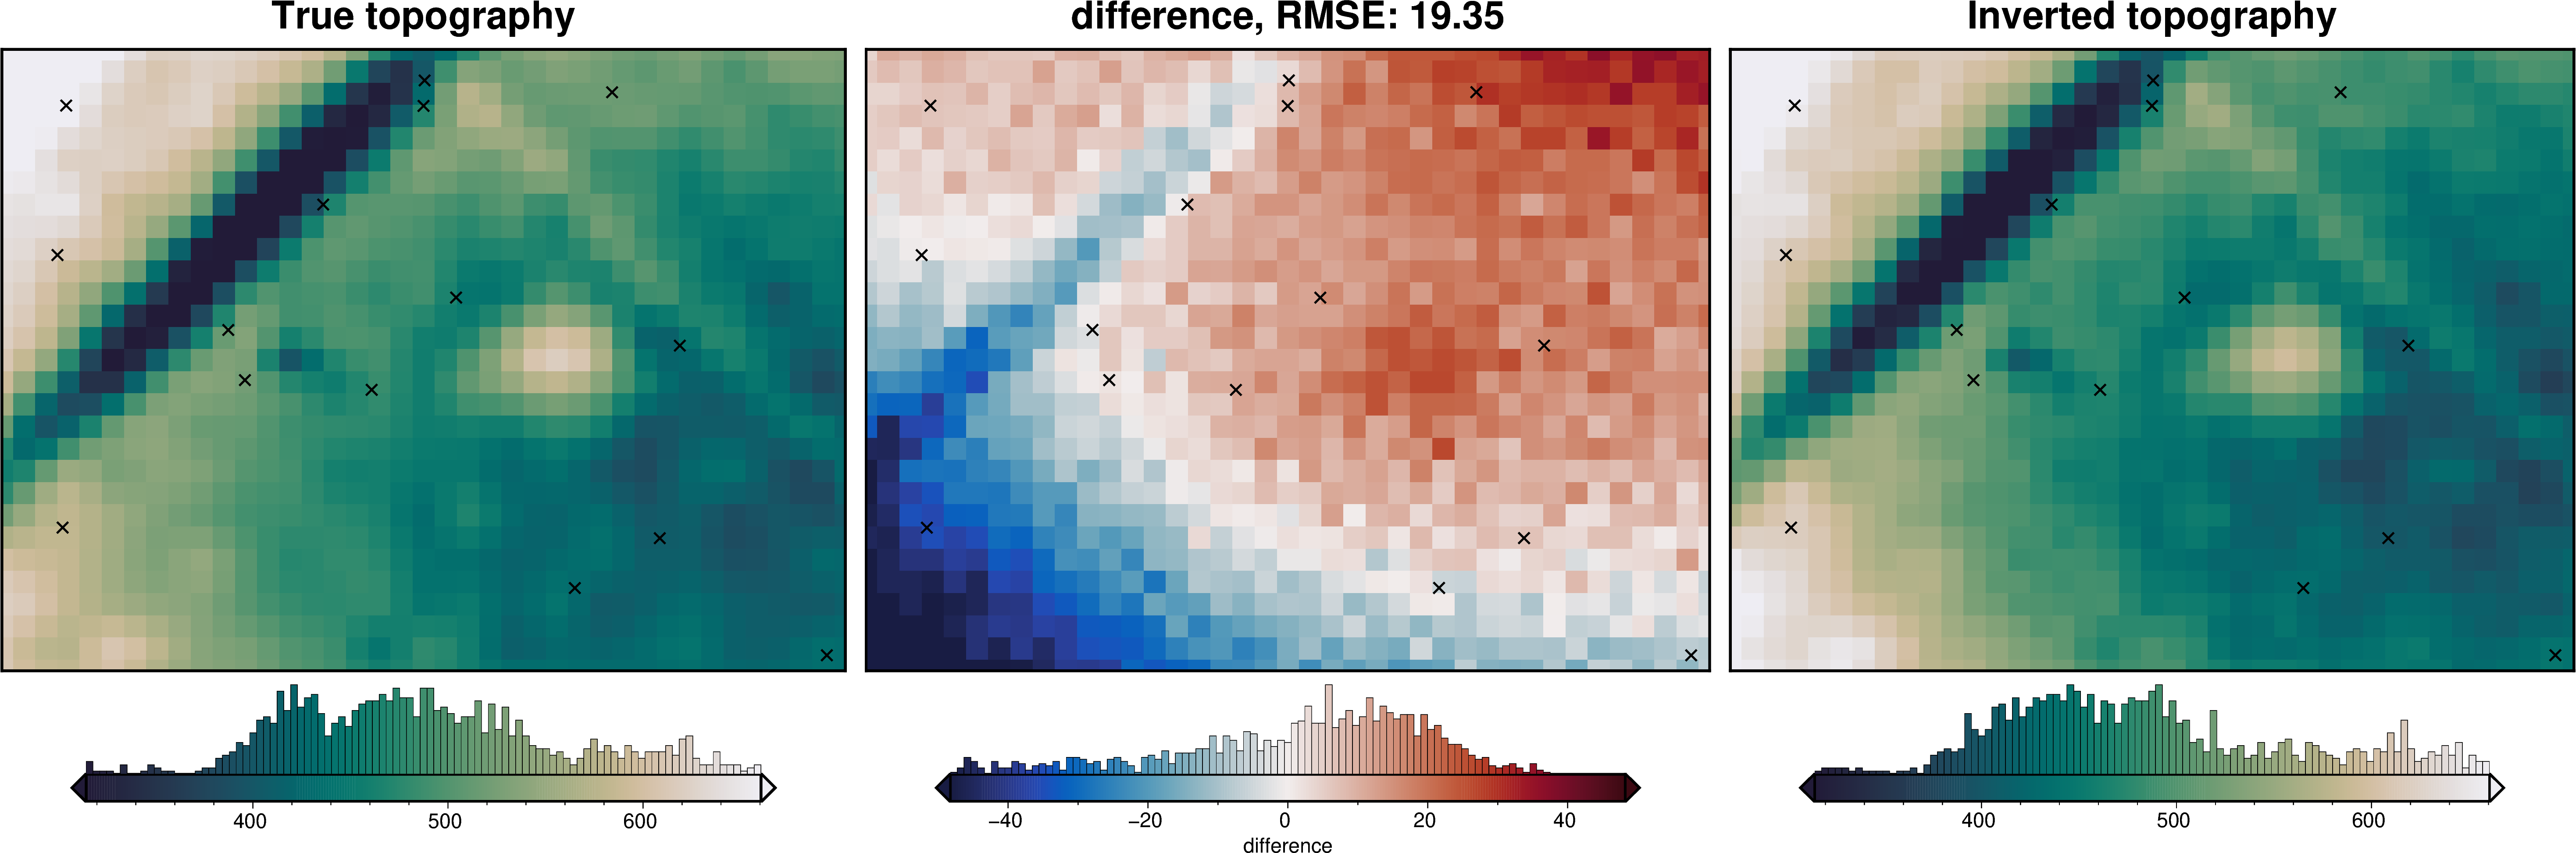

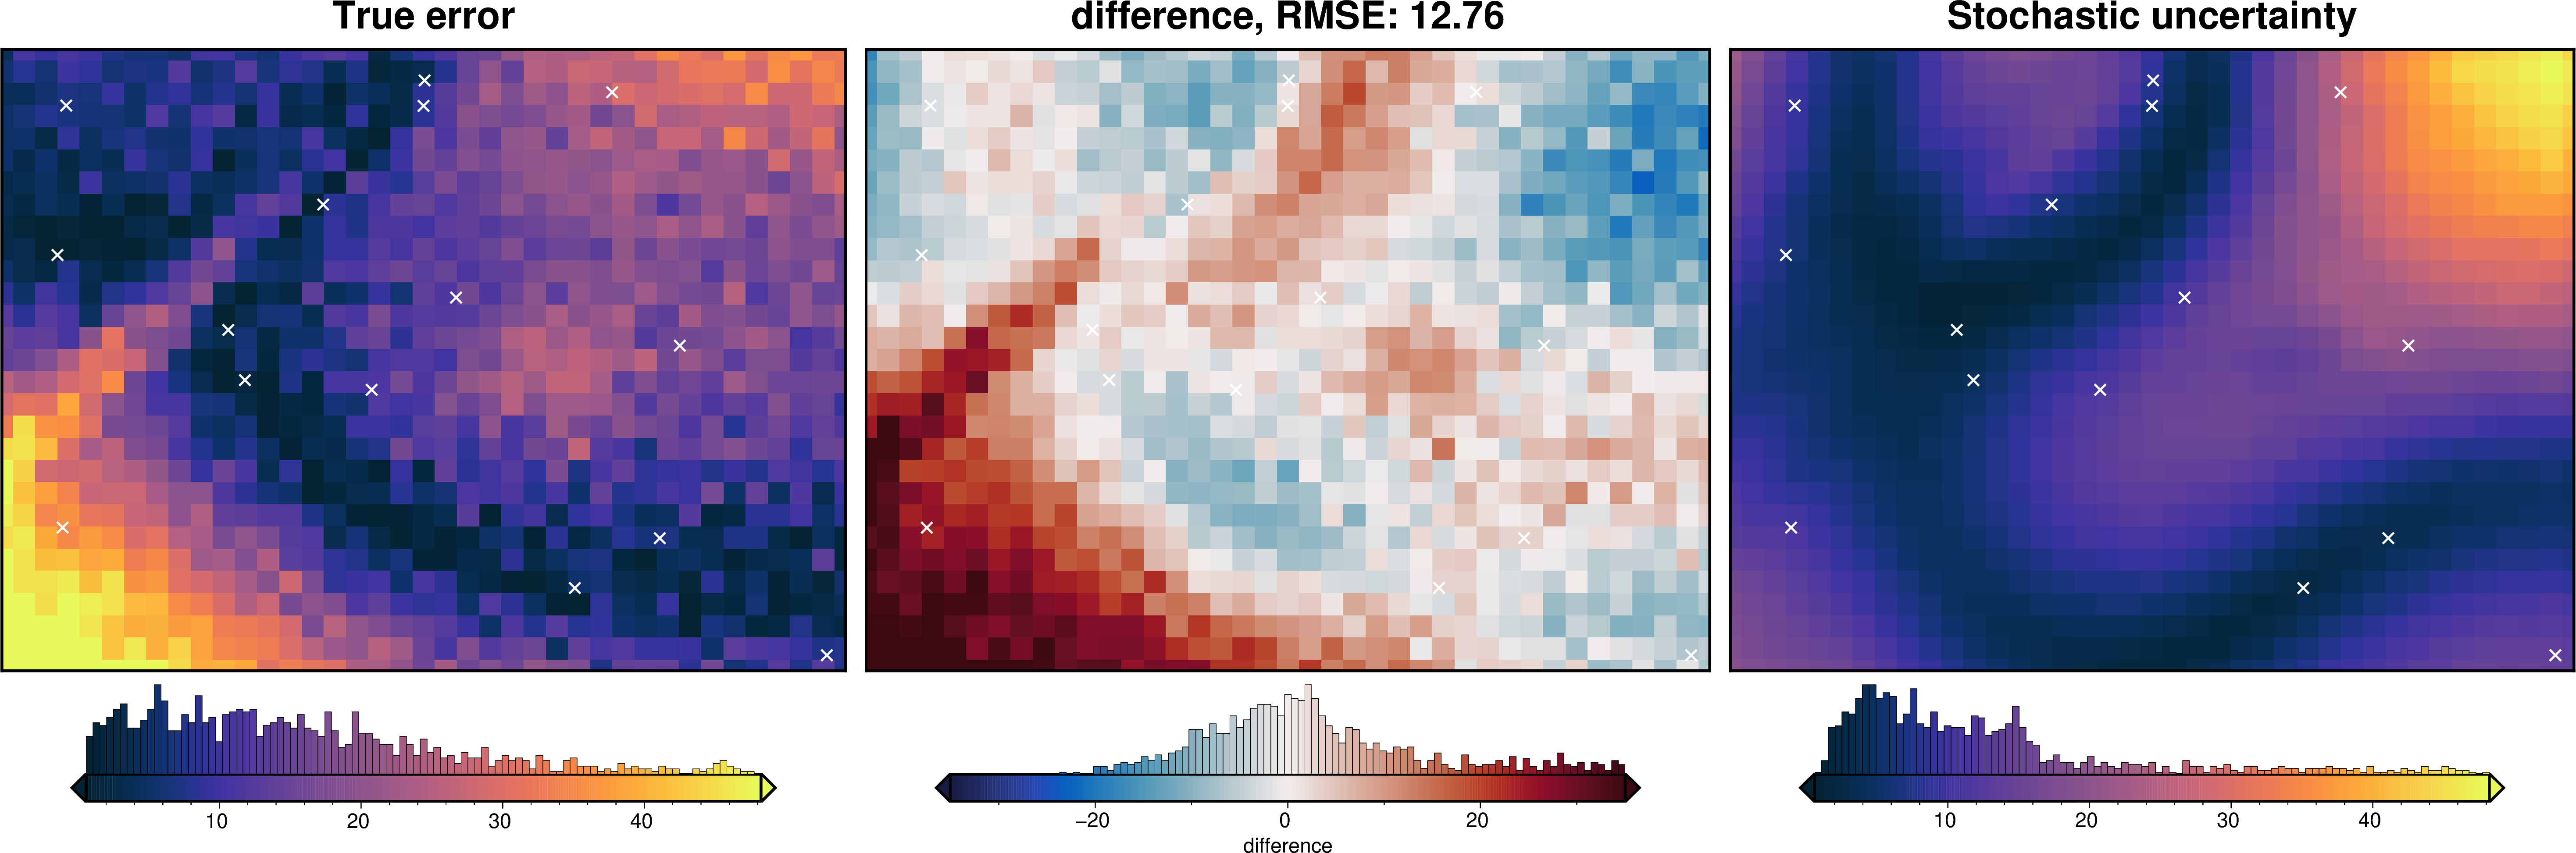

In [66]:
fname = "tmp/uncertainty_constraints"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_constraints_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    sample_constraints=True,
    constraints_df=constraint_points,
    starting_topography_kwargs=starting_topography_kwargs,
    runs=10,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_constraints_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Gravity component

INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_grav' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: 'tmp/uncertainty_grav'



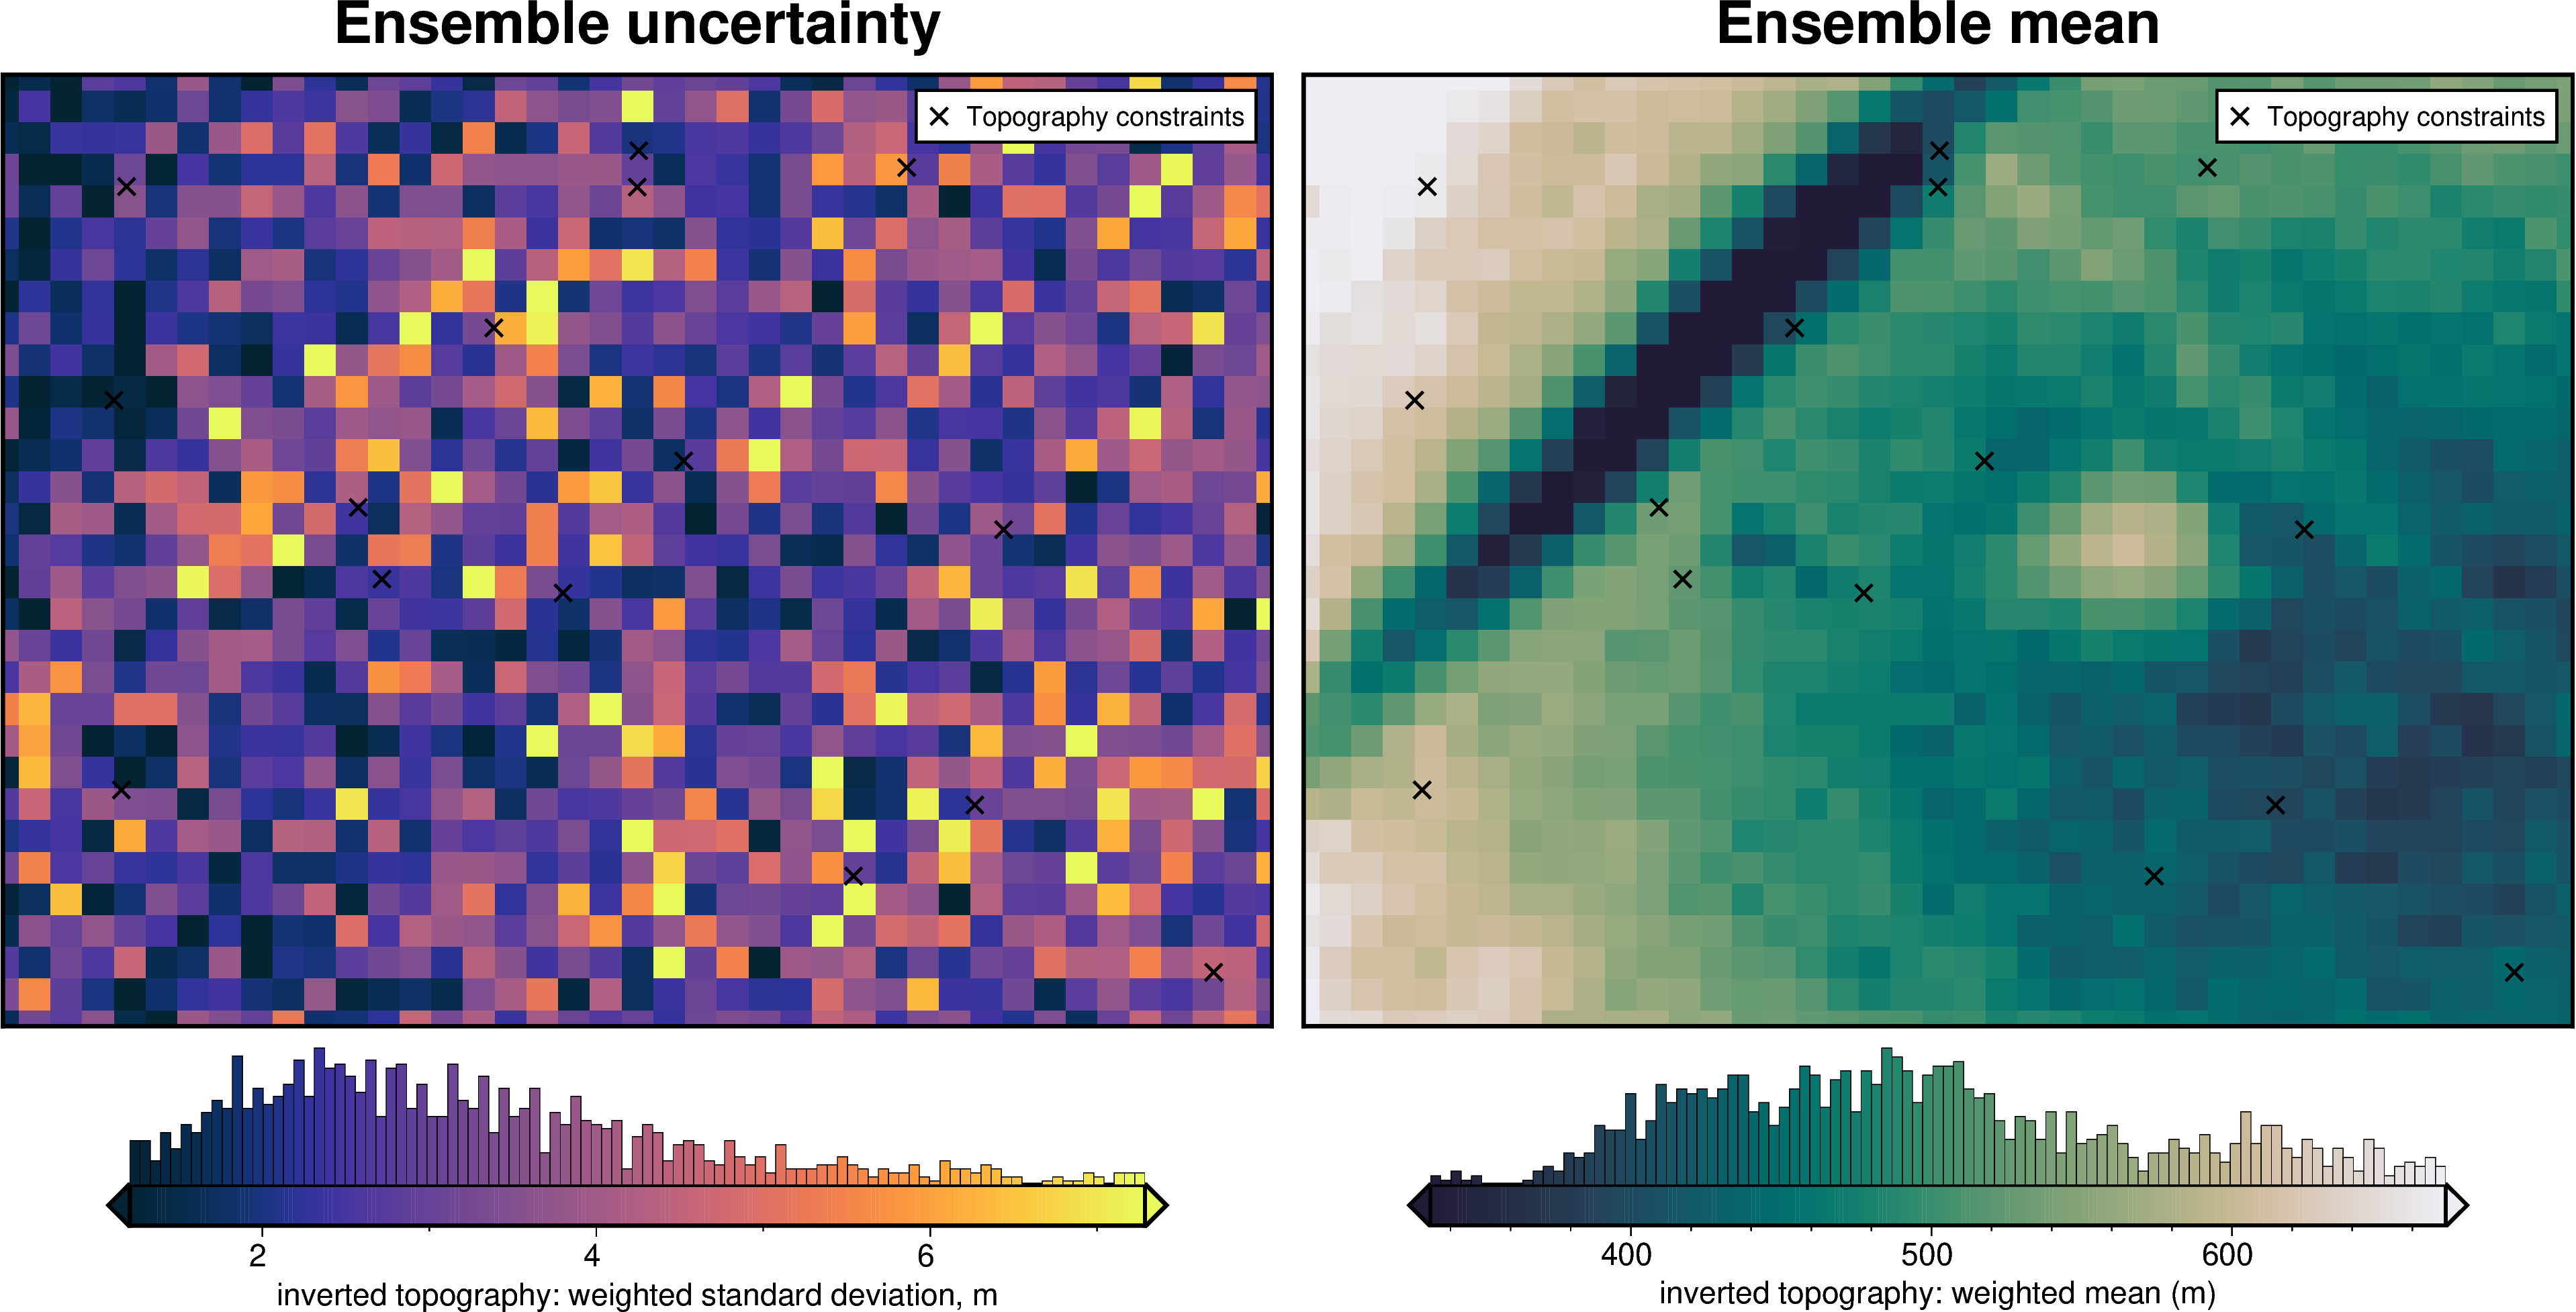

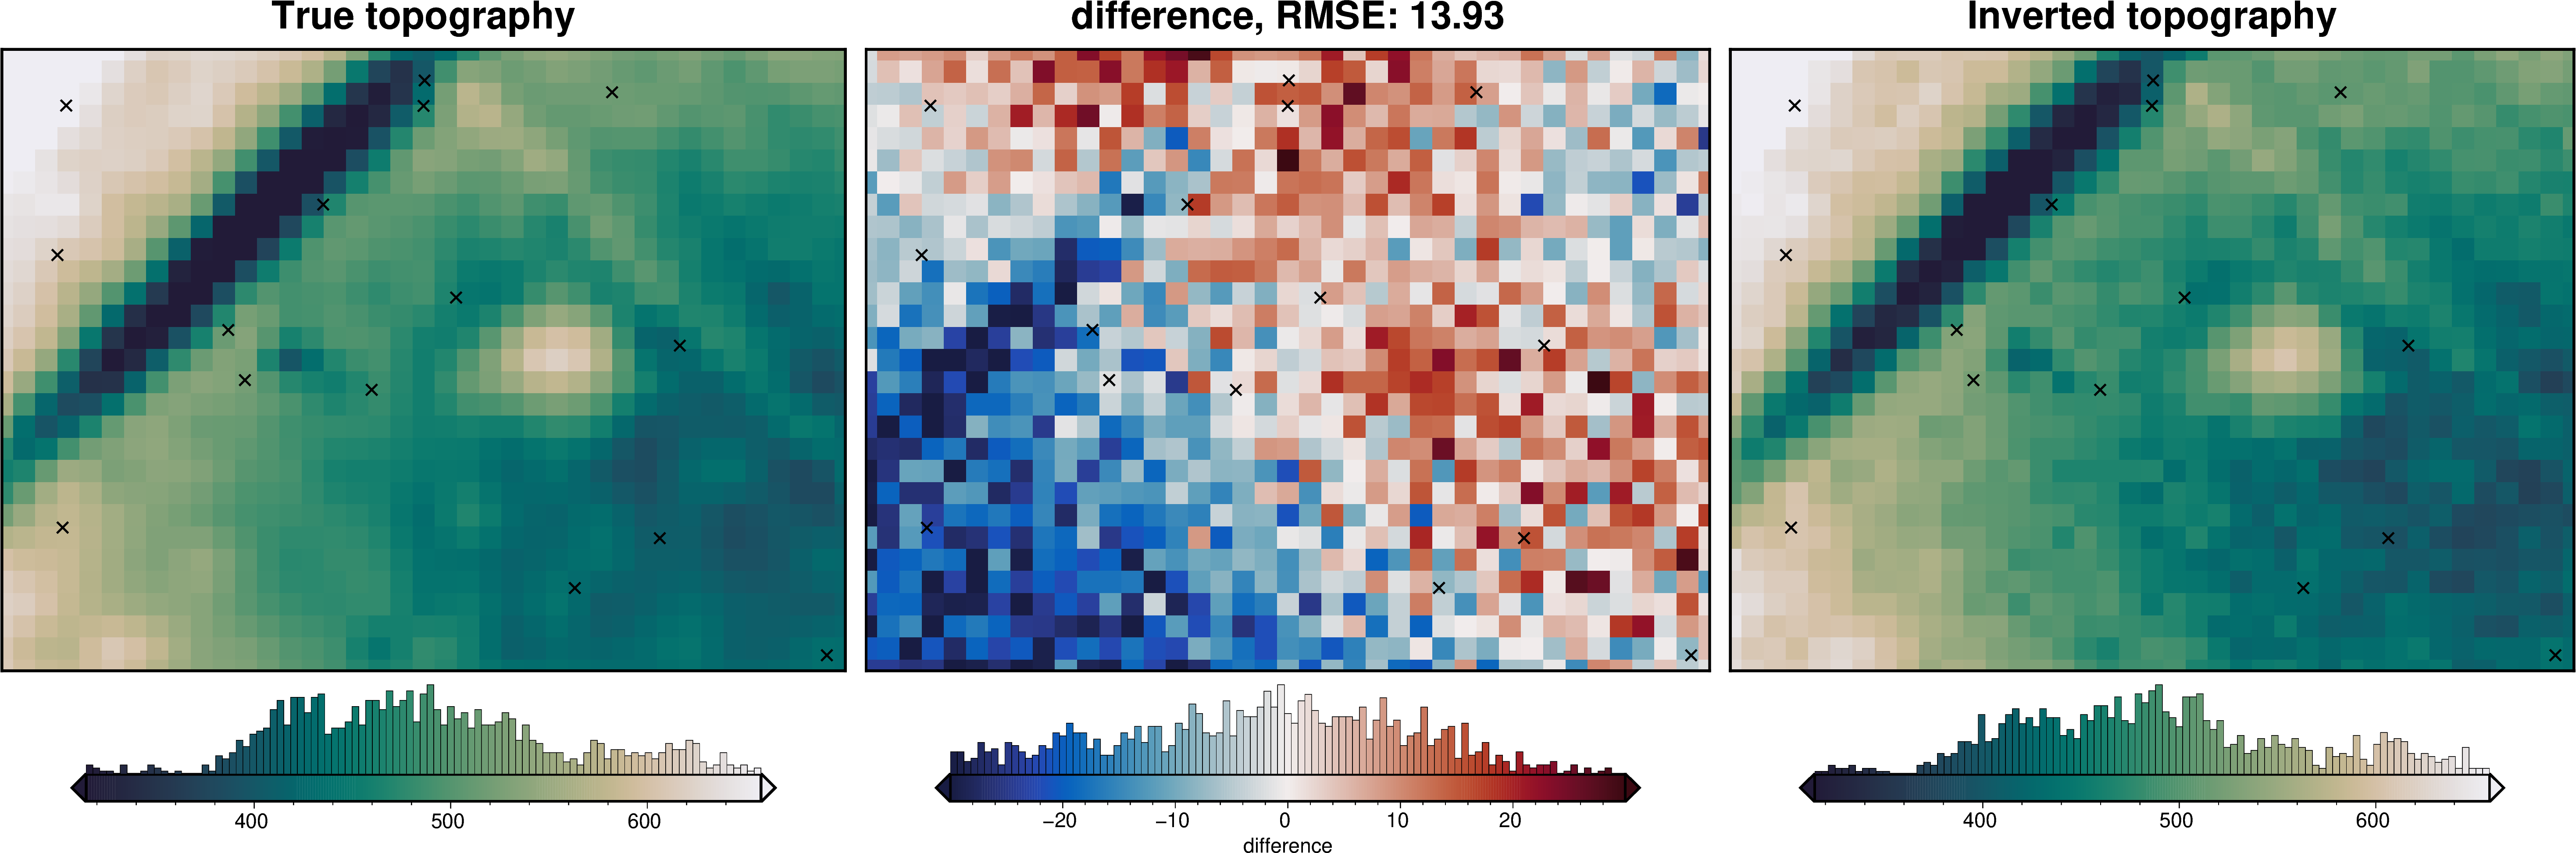

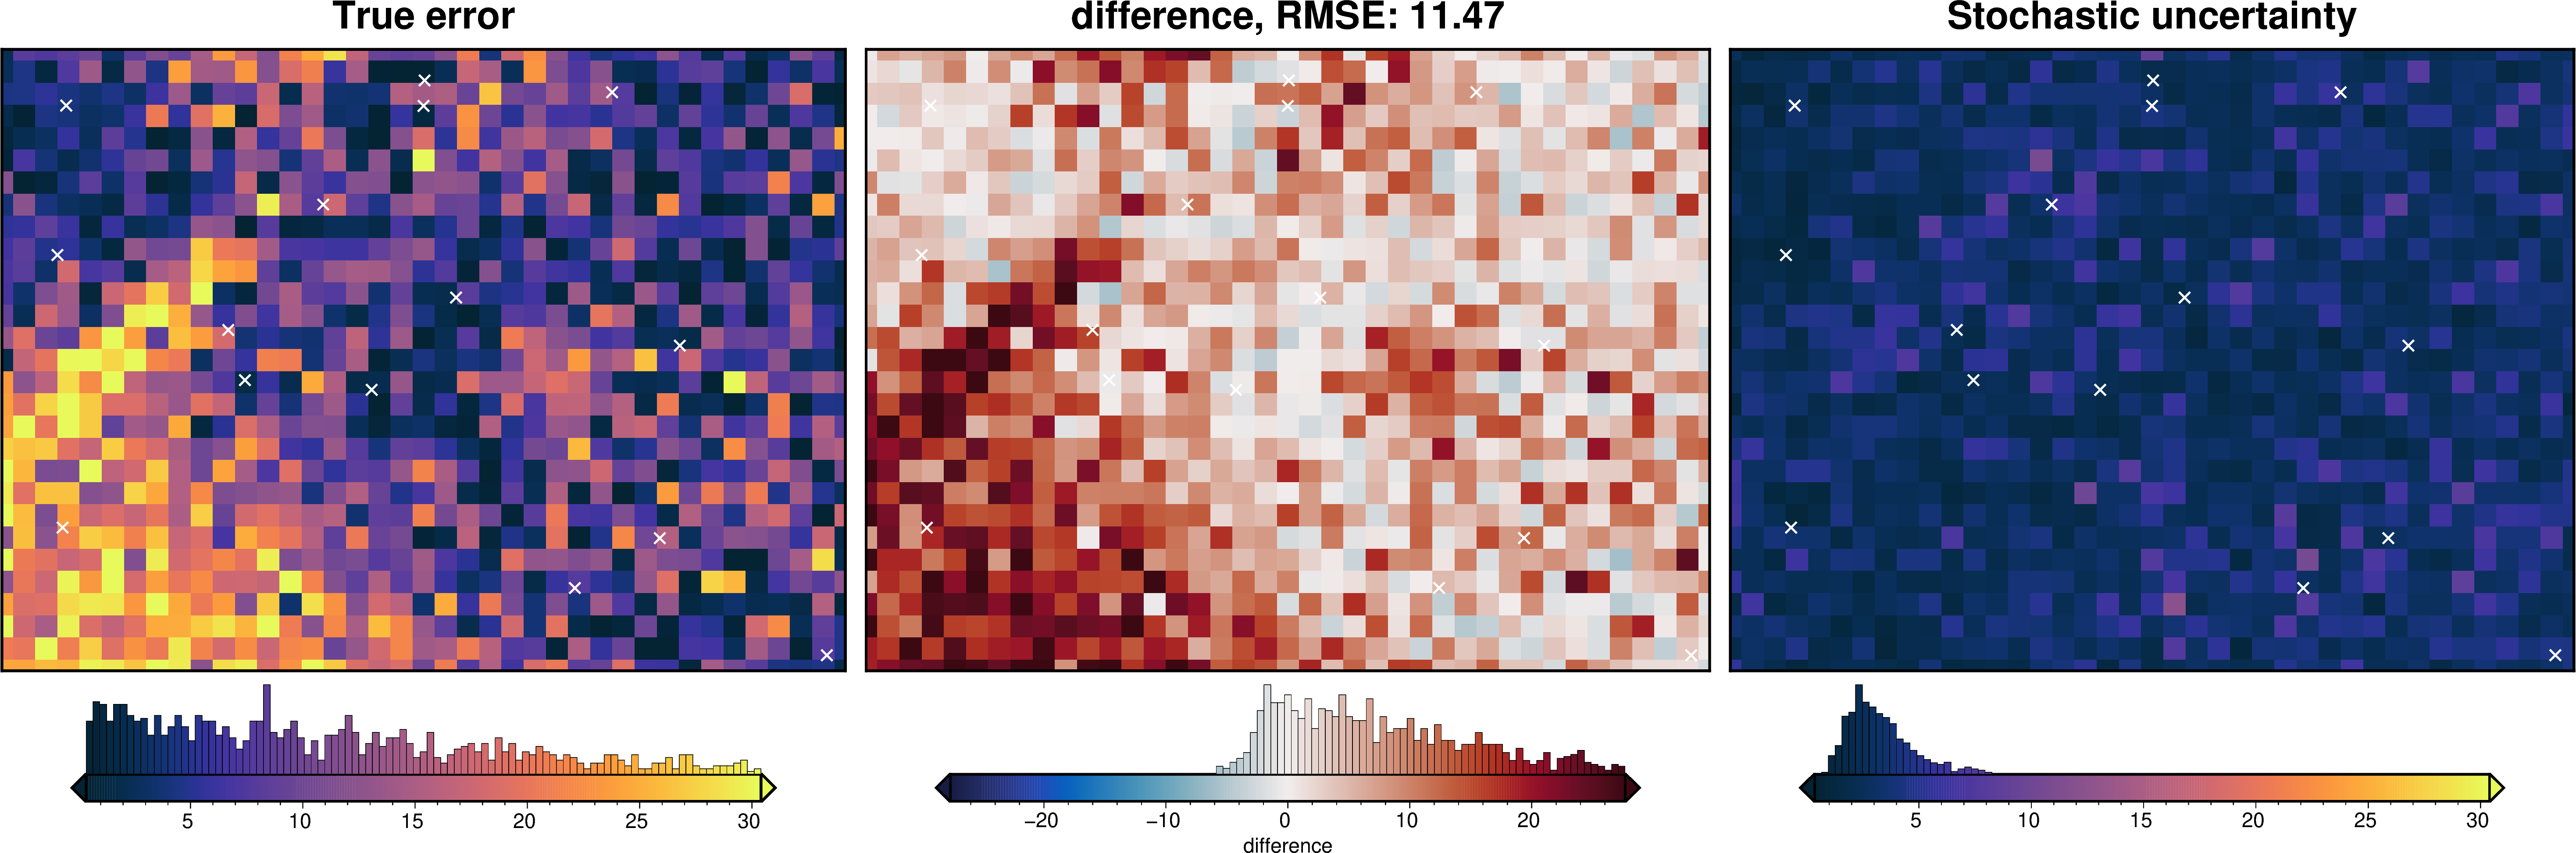

In [49]:
fname = "tmp/uncertainty_grav"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_grav_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    sample_gravity=True,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_grav_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Total uncertainty

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.03583141360899327, min: 0.0024811354130749273, max: 0.1780327798309552
INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 2857.9296283000003, min: 2525.6536416299646, max: 3190.205614970035
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_full' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_full'



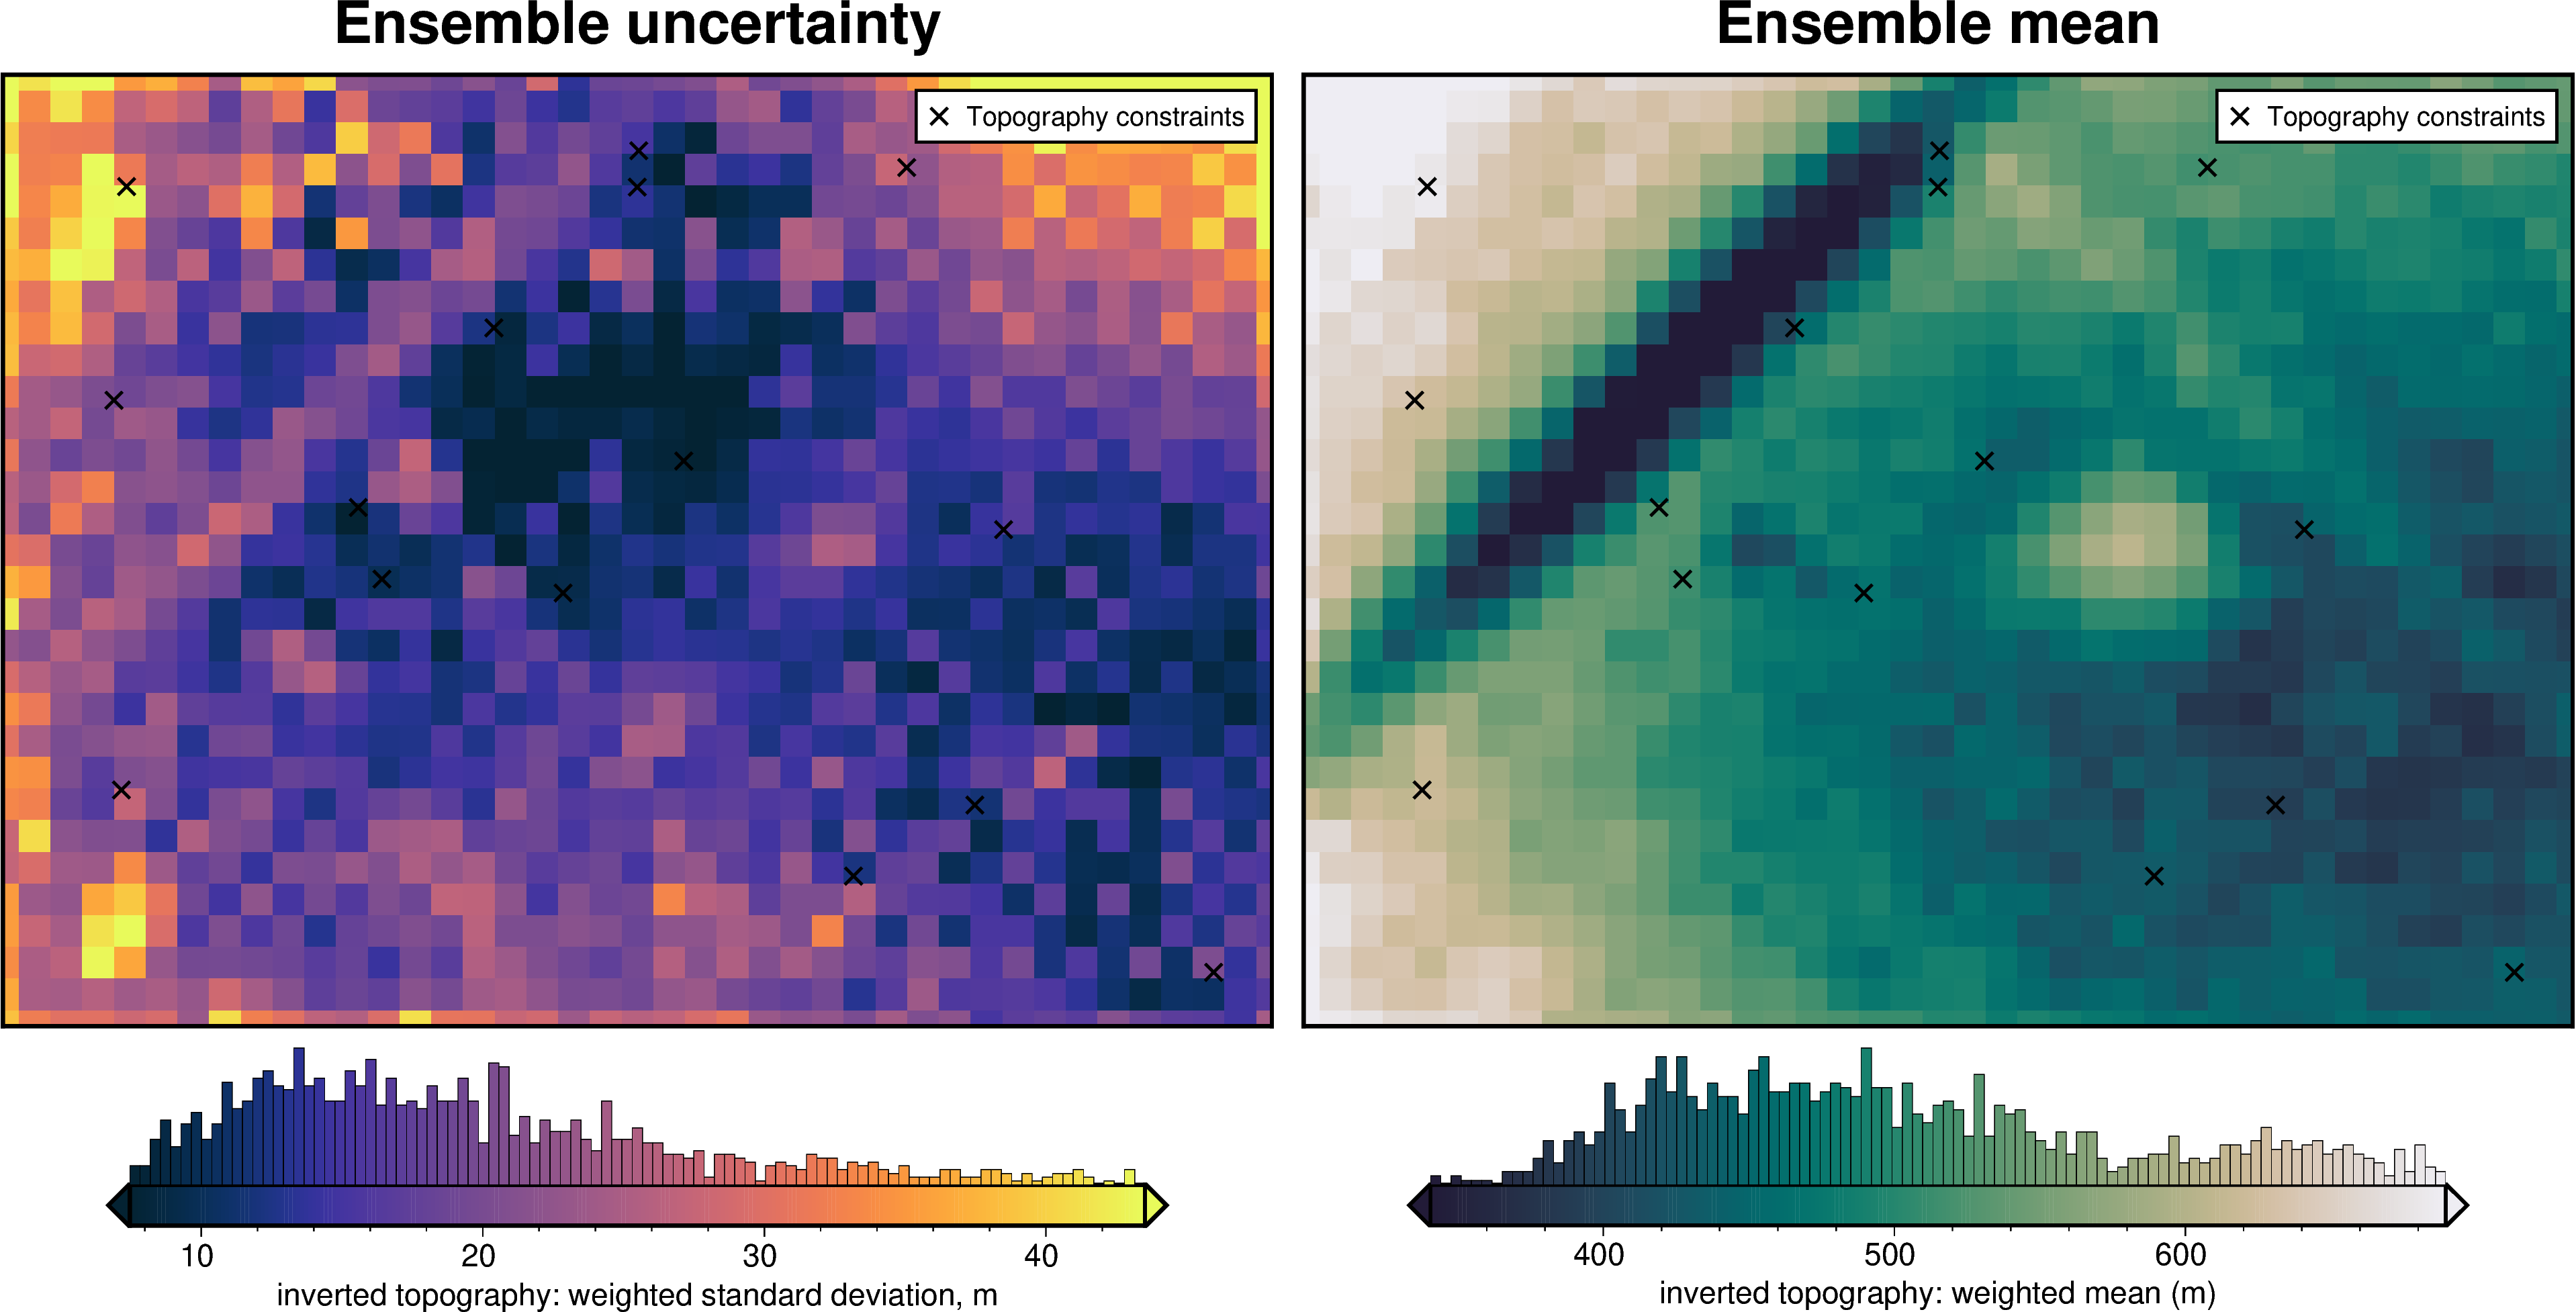

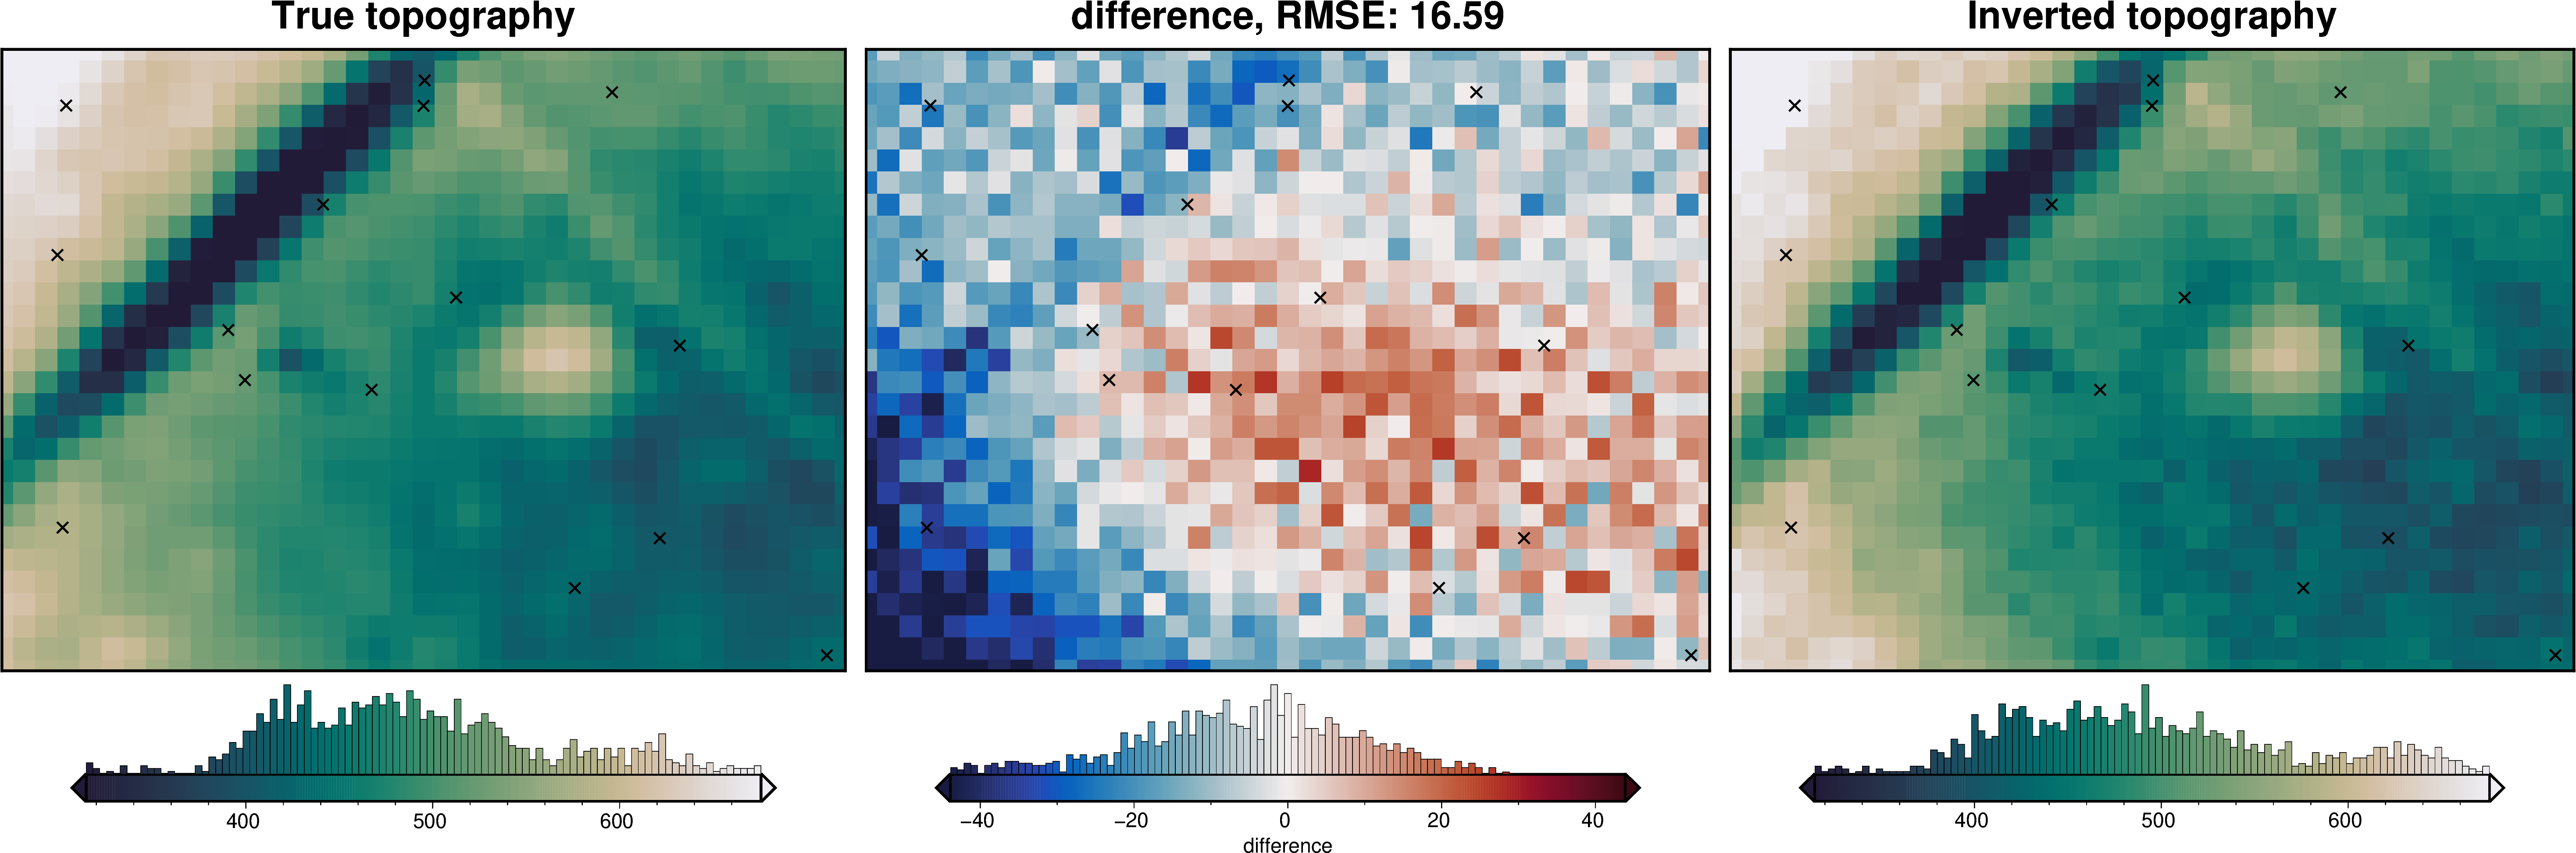

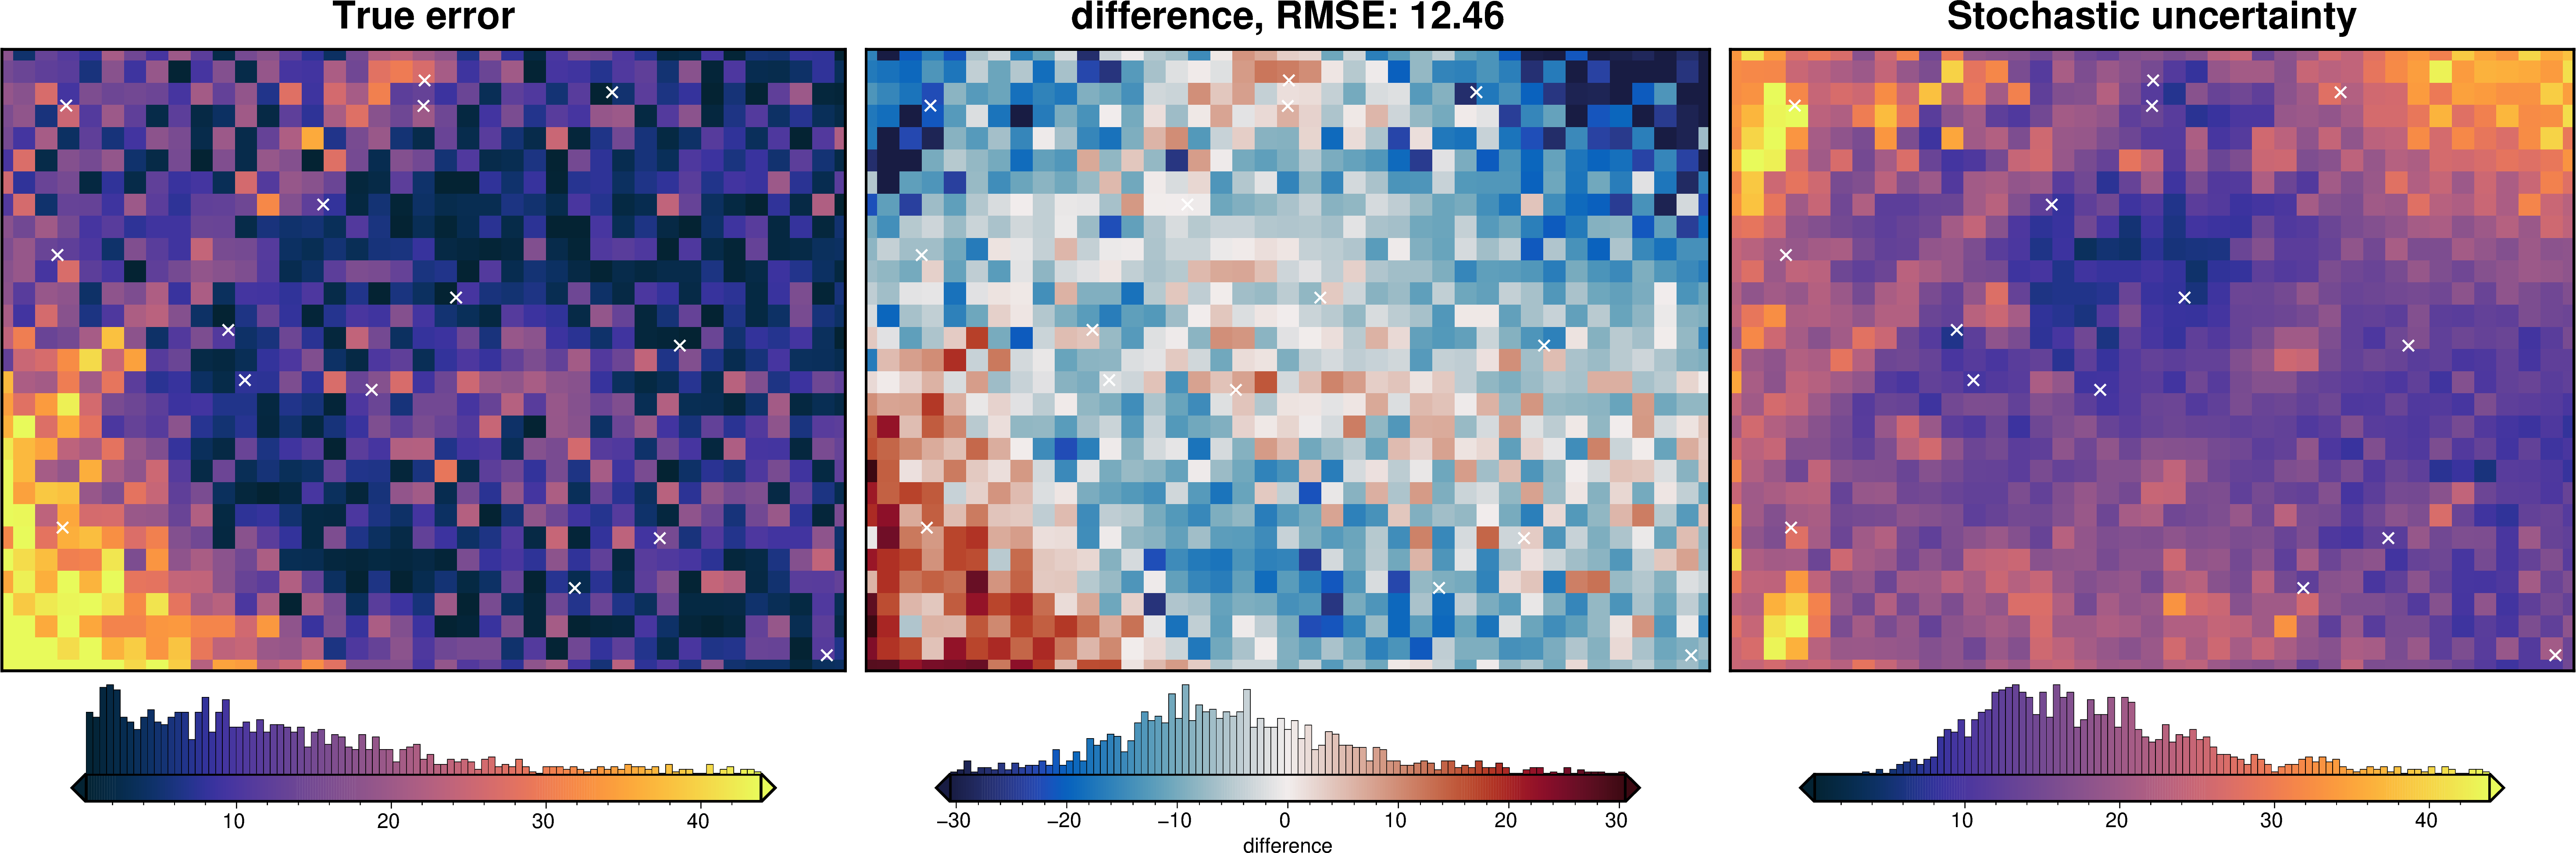

In [67]:
fname = "tmp/uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    sample_gravity=True,
    sample_constraints=True,
    constraints_df=constraint_points,
    parameter_dict=solver_dict | density_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    starting_topography_kwargs=starting_topography_kwargs,
    **uncert_kwargs,
)

stats_ds = uncert_plots(
    uncert_results,
    region,
    spacing,
    true_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
)

## Comparing results

In [68]:
results = [
    uncert_results,
    uncert_grav_results,
    uncert_constraints_results,
    uncert_density_results,
    uncert_damping_results,
]
names = [
    "full",
    "grav",
    "constraints",
    "density",
    "damping",
]
# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
        region=vd.pad_region(region, -spacing),
    )
    stats.append(ds)

In [69]:
# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 46kB
Dimensions:            (northing: 29, easting: 39)
Coordinates:
  * northing           (northing) float64 232B 1e+03 2e+03 ... 2.8e+04 2.9e+04
  * easting            (easting) float64 312B 1e+03 2e+03 ... 3.8e+04 3.9e+04
Data variables:
    full_stdev         (northing, easting) float64 9kB 24.81 24.39 ... 37.94
    grav_stdev         (northing, easting) float64 9kB 5.563 2.823 ... 2.796
    constraints_stdev  (northing, easting) float64 9kB 19.04 17.97 ... 44.44
    density_stdev      (northing, easting) float64 9kB 1.859 1.239 ... 1.926
    damping_stdev      (northing, easting) float64 9kB 2.831 0.5222 ... 2.612

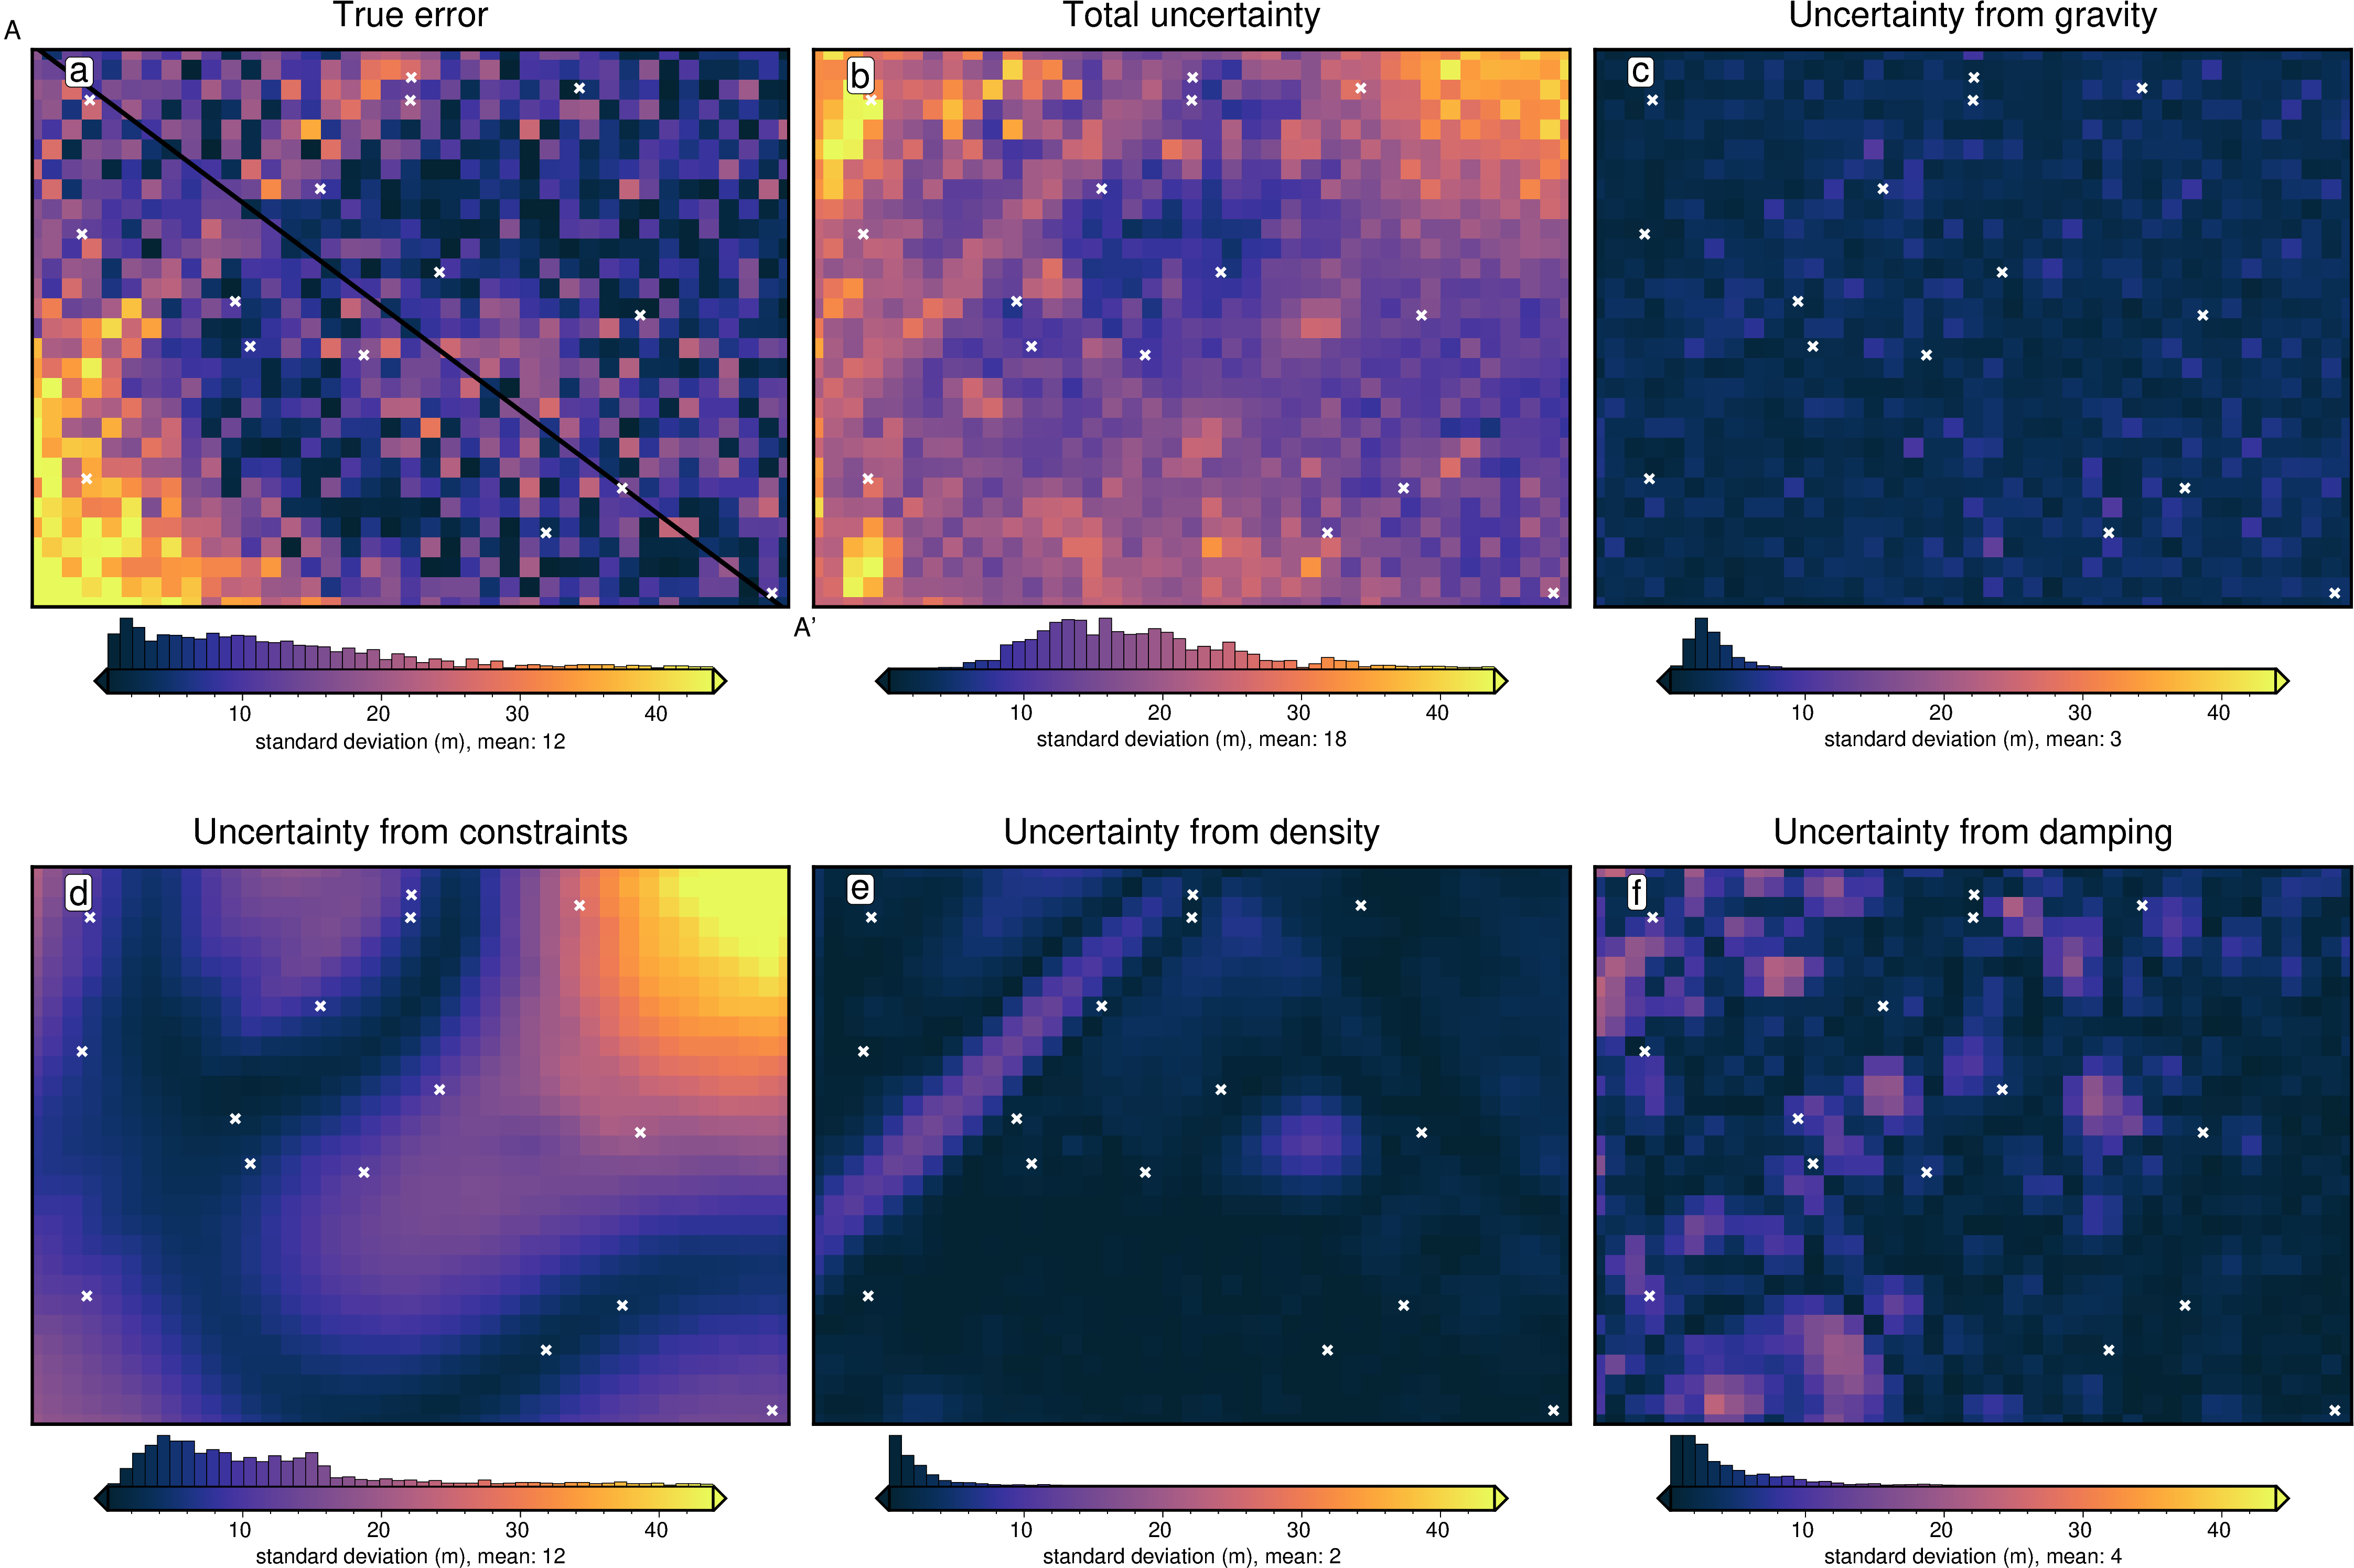

In [ ]:
titles = [
    "True error",
    "Total uncertainty",
    "Uncertainty from gravity",
    "Uncertainty from constraints",
    "Uncertainty from density",
    "Uncertainty from damping",
]
grids = list(merged.data_vars.values())

grids.insert(0, np.abs(stats[0].weighted_mean - true_topography))

cpt_lims = polar_utils.get_min_max(
    grids[0],
    robust=True,
)

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
    elif i == 3:
        origin_shift = "both"
        xshift_amount = -2
    else:
        origin_shift = "x"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap="thermal",
        cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    if i == 0:
        # plot profile location, and endpoints on map
        start = [region[0], region[3]]
        stop = [region[1], region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
    fig.plot(
        x=constraint_points.easting,
        y=constraint_points.northing,
        style="x.2c",
        pen="1.5p,white",
        fill="white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
fig.show()

grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


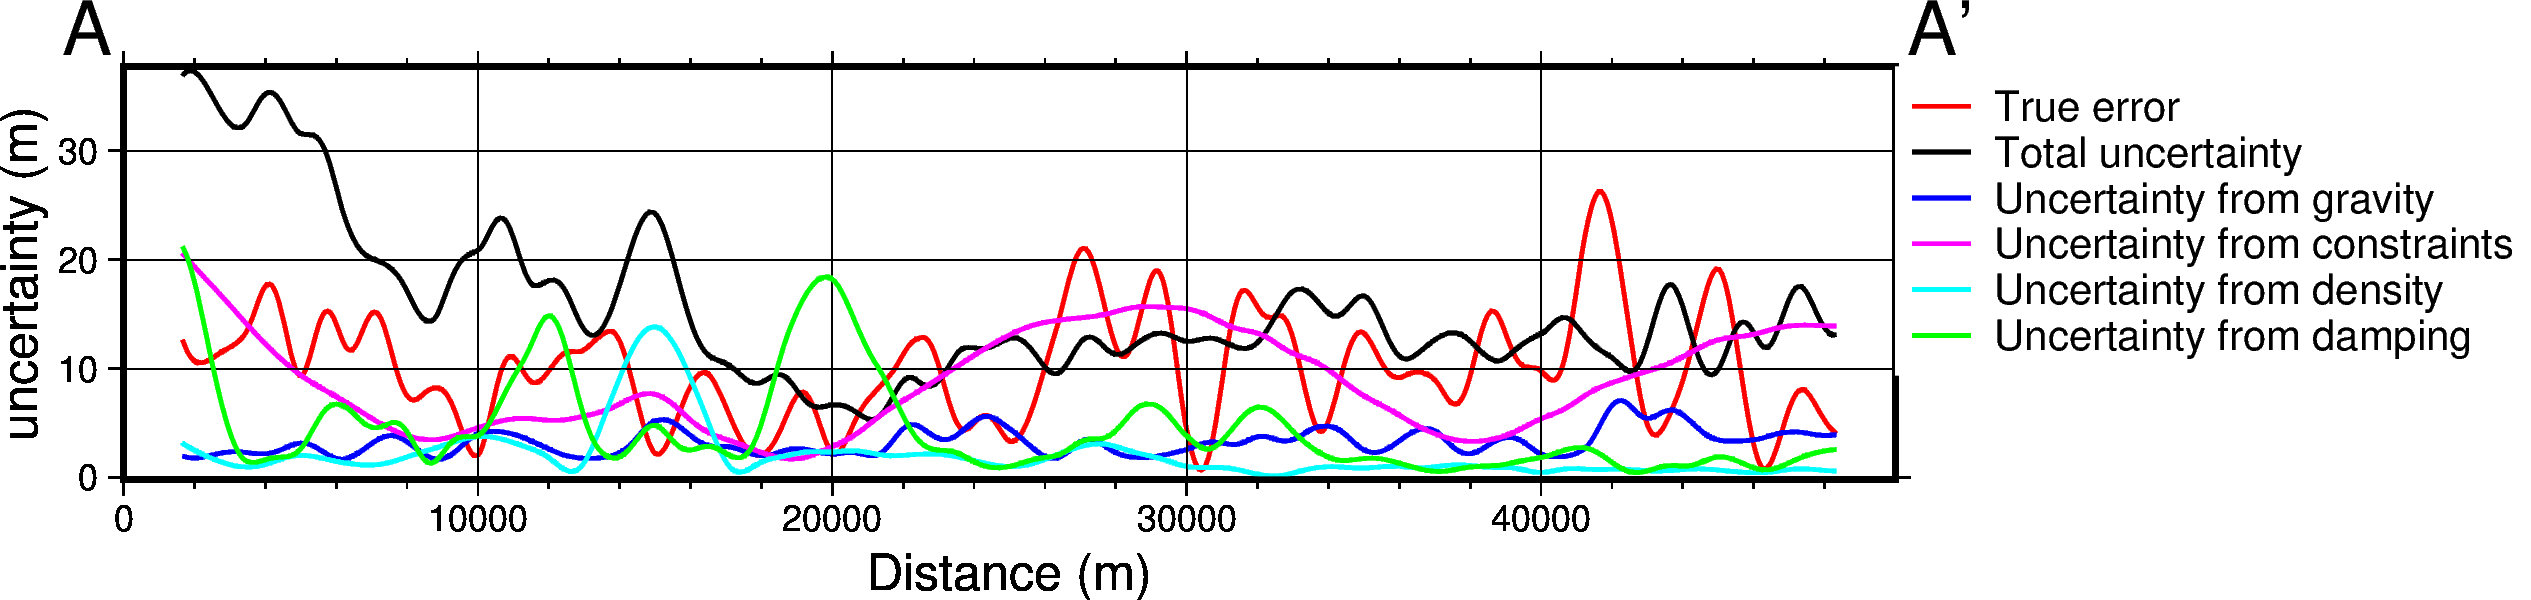

In [74]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[region[0], region[3]],
    stop=[region[1], region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()